In [1]:
import mdtraj as md
from glob import glob
import pyemma
import numpy as np
from simtk import unit

In [2]:
# time between saved snapshots
# (see variable `thinning` in `bayes_implicit_solvent/vacuum_samples/prepare_vacuum_samples.py`
# and variable `stepsize` in `bayes_implicit_solvent/solvation_free_energy.py`)
thinning_interval = 1000 * unit.femtosecond

In [3]:
traj_names = glob('../bayes_implicit_solvent/vacuum_samples/*.h5')
len(traj_names)

642

Potentially also include torsion features if I'm feeling fancy:

```python
def get_torsion_tuples(traj):
    """dumb brute-force O(n_bonds^3) iteration"""
    
    bonds = list([sorted((a.index, b.index)) for (a,b) in traj.top.bonds])
    torsions = []
    for bond1 in bonds:
        for bond2 in bonds:
            for bond3 in bonds:
                if (bond1[1] == bond2[0]) and (bond2[1] == bond3[0]):
                    torsions.append((bond1[0], bond1[1], bond2[1], bond3[1]))
    return torsions

def estimate_timescales(traj, lag=20, max_features=1500):
    """apply tICA to all pairwise distances and torsion angles and return timescale estimates"""
    feat = pyemma.coordinates.featurizer(traj.topology)
    feat.add_distances(np.arange(traj.n_atoms))
    feat.add_dihedrals(get_torsion_tuples(traj))
    
    if len(feat.describe()) > max_features:
        print("Warning! max_features exceeded ({} > {}), skipping this one and returning nans...".format(len(feat.describe()), max_features))
        return np.nan * np.zeros(max_features)
    
    X = feat.transform(traj)
    tica = pyemma.coordinates.tica(X, lag=lag)
    return tica.timescales```

In [4]:
def get_pairs(atom_list):
    """exclude redundancies"""
    pairs = []
    n = len(atom_list)
    for i in range(n):
        for j in range(i):
            pairs.append((atom_list[i], atom_list[j]))
    return pairs
    
def estimate_timescales(traj, lag=20):
    """apply tICA to all pairwise distances and return timescale estimates"""
    feat = pyemma.coordinates.featurizer(traj.topology)
    atom_list = feat.select_Heavy()
    if len(atom_list) > 1:
        pairs = get_pairs(atom_list)
    else:
        print('warning! not enough heavy atoms found -- falling back to all-pairs distances')
        pairs = get_pairs(np.arange(traj.n_atoms))
    feat.add_distances(pairs)
    X = feat.transform(traj)
    tica = pyemma.coordinates.tica(X, lag=lag)
    return tica.timescales

In [5]:
traj = md.load(traj_names[0])

In [6]:
timescales = []
from tqdm import tqdm
for traj_name in tqdm(traj_names):
    timescales.append(estimate_timescales(md.load(traj_name)))

 48%|████▊     | 306/642 [00:20<00:22, 14.76it/s]

warning! not enough heavy atoms found -- falling back to all-pairs distances


 79%|███████▉  | 509/642 [00:35<00:09, 14.22it/s]

warning! not enough heavy atoms found -- falling back to all-pairs distances


 96%|█████████▋| 619/642 [00:41<00:01, 14.95it/s]

warning! not enough heavy atoms found -- falling back to all-pairs distances


100%|██████████| 642/642 [00:42<00:00, 15.08it/s]


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

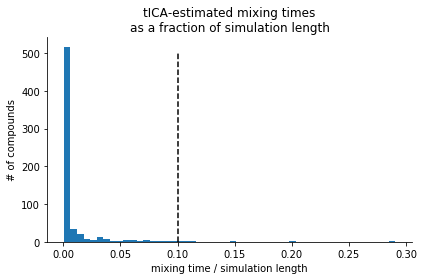

In [8]:
# what's the distribution of estimated mixing times, as a fraction of the simulation length?

mixing_times = np.array([t[0] for t in timescales])
ax = plt.subplot(1,1,1)
plt.hist(mixing_times / len(traj), bins=50);
plt.xlabel('mixing time / simulation length')
plt.ylabel('# of compounds')
plt.title('tICA-estimated mixing times\nas a fraction of simulation length')

plt.yticks([0,100,200,300,400,500])
#plt.ylim(-1,)
#plt.yscale('log')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.vlines(0.1,0,500,linestyles='--')

plt.tight_layout()
plt.savefig('tica-estimated-mixing-times.png', dpi=300, bbox_inches='tight')

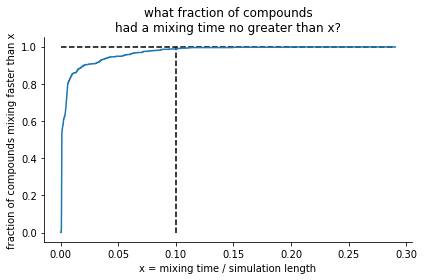

In [9]:
# let's also look at how many compounds mix faster than x, may be more useful representation of this information...

sorted_normalized_mixing_times = np.array(sorted([t[0] for t in timescales])) / len(traj)
thresholds = np.linspace(0, max(sorted_normalized_mixing_times), 10000)

fraction_below_threshold = [np.mean(sorted_normalized_mixing_times < threshold) for threshold in thresholds]


ax = plt.subplot(1,1,1)

plt.plot(thresholds, fraction_below_threshold)
#plt.fill_between(thresholds, fraction_below_threshold, alpha=0.1)

plt.hlines(1,min(thresholds), max(thresholds), linestyles='--')
plt.xlabel('x = mixing time / simulation length')
plt.ylabel('fraction of compounds mixing faster than x')

#plt.yticks([0,1])
#plt.xticks([0,0.25,0.5], ['0','0.25','0.5'])
plt.vlines(0.1,0,1,linestyles='--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('what fraction of compounds\nhad a mixing time no greater than x?')

plt.tight_layout()
plt.savefig('tica-estimated-mixing-times-fraction-below.png', dpi=300, bbox_inches='tight')

trajectory with slowest mixing time:  ../bayes_implicit_solvent/vacuum_samples/vacuum_samples_116.h5
328
['mobley_5200358', 'CC(C)(/C=N\\OC(=O)NC)SC', 'aldicarb', '-9.84', '0.10', '-9.68', '0.05', '10.1021/jp806724u', '10.1021/jp806838b', 'Renamed mobley_5200358 from aldicarb to [(Z)-(2-methyl-2-methylsulfanyl-propylidene)amino] N-methylcarbamate (the name from the 3D structure) since the former did not completely specify stereochemistry.  ']
# atoms:  26


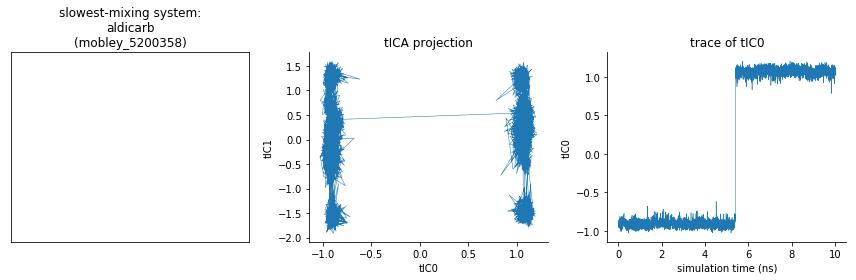

In [12]:
# Let's look more closely at the slowest-mixing system
from bayes_implicit_solvent.solvation_free_energy import smiles_list, db
filename_index_of_slowest_one = np.argmax(mixing_times)

def parse_index_from_fname(fname):
    fname = fname.split('_')[-1]
    return int(fname[:fname.find('.h5')])

print('trajectory with slowest mixing time: ', traj_names[filename_index_of_slowest_one])

index_of_slowest_one = parse_index_from_fname(traj_names[filename_index_of_slowest_one])

smiles = smiles_list[index_of_slowest_one]
for i in range(len(db)):
    if db[i][1] == smiles:
        print(i)
        print(db[i])
        break
db_id, name = db[i][0], db[i][2]
traj = md.load(traj_names[filename_index_of_slowest_one])
pairs = get_pairs(np.arange(traj.n_atoms))

feat = pyemma.coordinates.featurizer(traj.topology)
feat.add_distances(pairs)

X = feat.transform(traj)
tica = pyemma.coordinates.tica(X, lag=20)
y = tica.get_output()[0]


plt.figure(figsize=(12,4))

# placeholder for chemical structure
ax = plt.subplot(1,3,1)
plt.plot(np.nan, np.nan)
plt.xticks([])
plt.yticks([])
plt.title('slowest-mixing system:\n{}\n({})'.format(name, db_id))

ax = plt.subplot(1,3,2)

plt.plot(y[:,0], y[:,1], linewidth=0.5)
plt.xlabel('tIC0')
plt.ylabel('tIC1')
plt.title('tICA projection')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax = plt.subplot(1,3,3)

t = np.arange(len(y)) * thinning_interval / unit.nanosecond
plt.plot(t, y[:,0], linewidth=0.5)
plt.xlabel('simulation time (ns)')
plt.ylabel('tIC0')
plt.title('trace of tIC0')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

print('# atoms: ', traj.n_atoms)
plt.savefig('slowest-mixing-tica-projection.png', dpi=300, bbox_inches='tight')

In [13]:
smiles_list[index_of_slowest_one], smiles_list[i]

('CC(C)(/C=N\\OC(=O)NC)SC', 'C1CCCC(CC1)O')

In [14]:
db[i]

['mobley_5200358',
 'CC(C)(/C=N\\OC(=O)NC)SC',
 'aldicarb',
 '-9.84',
 '0.10',
 '-9.68',
 '0.05',
 '10.1021/jp806724u',
 '10.1021/jp806838b',
 'Renamed mobley_5200358 from aldicarb to [(Z)-(2-methyl-2-methylsulfanyl-propylidene)amino] N-methylcarbamate (the name from the 3D structure) since the former did not completely specify stereochemistry.  ']

In [15]:
from bayes_implicit_solvent.solvation_free_energy import mol_top_sys_pos_list
mol, top, sys, pos = mol_top_sys_pos_list[index_of_slowest_one]
mol_atoms = [a.GetName() for a in mol.GetAtoms()]
print(mol_atoms)

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'N1', 'N2', 'O1', 'O2', 'S1', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14']


In [16]:
print([a for a in traj.top.atoms])

[0-C1, 0-C2, 0-C3, 0-C4, 0-C5, 0-C6, 0-C7, 0-N1, 0-N2, 0-O1, 0-O2, 0-S1, 0-H1, 0-H2, 0-H3, 0-H4, 0-H5, 0-H6, 0-H7, 0-H8, 0-H9, 0-H10, 0-H11, 0-H12, 0-H13, 0-H14]


In [17]:
name

'aldicarb'

In [18]:
# let's get some snapshots of these 2 long-lived states
traj = traj.superpose(traj[1000])

In [19]:
# just eye-balling it
state0 = traj[2000:2010]
state1 = traj[8000:8010]

In [20]:
state0.save_pdb('state0.pdb')
state1.save_pdb('state1.pdb')

In [21]:
transition_frame = np.argmax(y[:,0] > 0)

In [22]:
transition = traj[transition_frame-5:transition_frame+5]
transition = transition.superpose(transition)
transition.save_pdb('transition.pdb')

trajectory with fastest mixing time:  ../bayes_implicit_solvent/vacuum_samples/vacuum_samples_637.h5
# atoms:  6


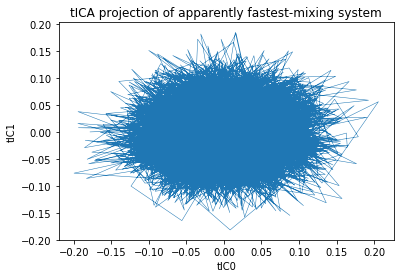

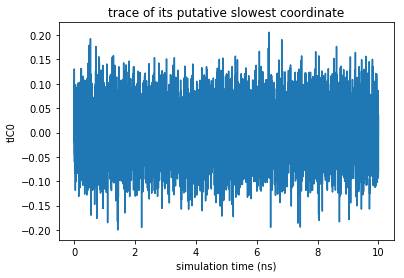

In [23]:
# And at the fastest-mixing system
index_of_fastest_one = np.argmin(mixing_times)
print('trajectory with fastest mixing time: ', traj_names[index_of_fastest_one])
traj = md.load(traj_names[index_of_fastest_one])
pairs = get_pairs(np.arange(traj.n_atoms))

feat = pyemma.coordinates.featurizer(traj.topology)
feat.add_distances(pairs)

X = feat.transform(traj)
tica = pyemma.coordinates.tica(X, lag=20)
y = tica.get_output()[0]

plt.plot(y[:,0], y[:,1], linewidth=0.5)
plt.xlabel('tIC0')
plt.ylabel('tIC1')
plt.title('tICA projection of apparently fastest-mixing system')

plt.figure()
t = np.arange(len(y)) * thinning_interval / unit.nanosecond
plt.plot(t, y[:,0])
plt.xlabel('simulation time (ns)')
plt.ylabel('tIC0')
plt.title('trace of its putative slowest coordinate')

print('# atoms: ', traj.n_atoms)

In [24]:
# what was the median?
np.median(mixing_times / len(traj))

0.0008627046497327493

In [25]:
# what fraction of simulations were at least 10x longer than estimated mixing time?
np.mean((mixing_times / len(traj)) < 0.1)

0.9875389408099688

In [26]:
# what fraction of simulations were at least 100x longer than estimated mixing time?
np.mean((mixing_times / len(traj)) < 0.01)

0.8551401869158879

In [27]:
# what fraction of simulations were at least 1x longer than estimated mixing time?
np.mean((mixing_times / len(traj)) < 1.0)

1.0

In [28]:
# simulations to extend
len(np.arange(len(mixing_times))[((mixing_times / len(traj)) > 0.1)])

8

In [29]:
# simulations to extend
len(np.arange(len(mixing_times))[((mixing_times / len(traj)) > 0.01)])

93

In [30]:
# let's further do a rudimentary MSM analysis of each trajectory

def estimate_timescales_using_msm(traj, lag=20, n_states=100):
    """apply tICA to all pairwise distances, then estimate a MSM and return it for further analysis"""
    feat = pyemma.coordinates.featurizer(traj.topology)
    atom_list = feat.select_Heavy()
    if len(atom_list) > 1:
        pairs = get_pairs(atom_list)
    else:
        print('warning! not enough heavy atoms found -- falling back to all-pairs distances')
        pairs = get_pairs(np.arange(traj.n_atoms))
    feat.add_distances(pairs)

    X = feat.transform(traj)
    tica = pyemma.coordinates.tica(X, lag=lag, kinetic_map=False, commute_map=True)
    y = tica.get_output()
    kmeans = pyemma.coordinates.cluster_mini_batch_kmeans(y, k=n_states, max_iter=100)
    dtraj = kmeans.get_output()[0].flatten()
    msm = pyemma.msm.estimate_markov_model(dtraj, lag)
    return msm

In [31]:
msms = []
for traj_name in tqdm(traj_names):
    msms.append(estimate_timescales_using_msm(md.load(traj_name)))

  0%|          | 0/642 [00:00<?, ?it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:48 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2580] INFO     Cluster centers converged after 11 steps.


  0%|          | 1/642 [00:00<05:43,  1.87it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:49 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2586] INFO     Cluster centers converged after 11 steps.


  0%|          | 2/642 [00:00<04:55,  2.17it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:49 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2592] INFO     Cluster centers converged after 1 steps.


  0%|          | 3/642 [00:01<04:18,  2.47it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:49 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2598] INFO     Cluster centers converged after 1 steps.


  1%|          | 4/642 [00:01<03:46,  2.81it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:50 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2604] INFO     Cluster centers converged after 10 steps.


  1%|          | 5/642 [00:02<04:37,  2.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:50 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2610] INFO     Cluster centers converged after 1 steps.


  1%|          | 6/642 [00:02<04:15,  2.49it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:50 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2616] INFO     Cluster centers converged after 1 steps.


  1%|          | 7/642 [00:02<03:57,  2.67it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:51 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2622] INFO     Cluster centers converged after 10 steps.


  1%|          | 8/642 [00:02<03:55,  2.69it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:51 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2628] INFO     Cluster centers converged after 13 steps.


  1%|▏         | 9/642 [00:03<03:55,  2.69it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:51 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2634] INFO     Cluster centers converged after 1 steps.


  2%|▏         | 10/642 [00:03<03:43,  2.83it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:52 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2640] INFO     Cluster centers converged after 5 steps.


  2%|▏         | 11/642 [00:03<03:37,  2.90it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:52 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2646] INFO     Cluster centers converged after 1 steps.


  2%|▏         | 12/642 [00:04<03:31,  2.98it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:52 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2652] INFO     Cluster centers converged after 8 steps.


  2%|▏         | 13/642 [00:04<03:32,  2.97it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:52 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2658] INFO     Cluster centers converged after 4 steps.


  2%|▏         | 14/642 [00:04<03:29,  2.99it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:53 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2664] INFO     Cluster centers converged after 1 steps.


  2%|▏         | 15/642 [00:04<03:23,  3.08it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:53 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2670] INFO     Cluster centers converged after 1 steps.


  2%|▏         | 16/642 [00:05<03:19,  3.15it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:53 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2676] INFO     Cluster centers converged after 4 steps.


  3%|▎         | 17/642 [00:05<03:17,  3.16it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:53 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2682] INFO     Cluster centers converged after 8 steps.


  3%|▎         | 18/642 [00:05<03:18,  3.15it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:54 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2688] INFO     Cluster centers converged after 7 steps.


  3%|▎         | 19/642 [00:06<03:18,  3.13it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:54 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2694] INFO     Cluster centers converged after 15 steps.


  3%|▎         | 20/642 [00:06<03:21,  3.08it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:54 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2700] INFO     Cluster centers converged after 1 steps.


  3%|▎         | 21/642 [00:06<03:17,  3.15it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:55 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2706] INFO     Cluster centers converged after 1 steps.


  3%|▎         | 22/642 [00:06<03:13,  3.20it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:55 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2712] INFO     Cluster centers converged after 1 steps.


  4%|▎         | 23/642 [00:07<03:08,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:55 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2718] INFO     Cluster centers converged after 1 steps.


  4%|▎         | 24/642 [00:07<03:04,  3.35it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:55 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2724] INFO     Cluster centers converged after 1 steps.


  4%|▍         | 25/642 [00:07<03:02,  3.39it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:55 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2730] INFO     Cluster centers converged after 1 steps.


  4%|▍         | 26/642 [00:07<03:00,  3.41it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:56 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2736] INFO     Cluster centers converged after 12 steps.


  4%|▍         | 27/642 [00:08<03:02,  3.37it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:56 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2742] INFO     Cluster centers converged after 10 steps.


  4%|▍         | 28/642 [00:08<03:04,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:56 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2748] INFO     Cluster centers converged after 1 steps.


  5%|▍         | 29/642 [00:08<03:02,  3.36it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:57 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2754] INFO     Cluster centers converged after 1 steps.


  5%|▍         | 30/642 [00:08<03:00,  3.39it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:57 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2760] INFO     Cluster centers converged after 14 steps.


  5%|▍         | 31/642 [00:09<03:04,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:57 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2766] INFO     Cluster centers converged after 1 steps.


  5%|▍         | 32/642 [00:09<03:02,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:58 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2772] INFO     Cluster centers converged after 1 steps.


  5%|▌         | 33/642 [00:09<03:03,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:58 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2778] INFO     Cluster centers converged after 1 steps.


  5%|▌         | 34/642 [00:10<03:01,  3.36it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:58 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2784] INFO     Cluster centers converged after 4 steps.


  5%|▌         | 35/642 [00:10<02:59,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:58 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2790] INFO     Cluster centers converged after 1 steps.


  6%|▌         | 36/642 [00:10<02:58,  3.40it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:59 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2796] INFO     Cluster centers converged after 1 steps.


  6%|▌         | 37/642 [00:10<02:55,  3.44it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:59 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2802] INFO     Cluster centers converged after 3 steps.


  6%|▌         | 38/642 [00:10<02:54,  3.47it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:59 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2808] INFO     Cluster centers converged after 1 steps.


  6%|▌         | 39/642 [00:11<02:52,  3.51it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:59 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2814] INFO     Cluster centers converged after 1 steps.


  6%|▌         | 40/642 [00:11<02:51,  3.52it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:49:59 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2820] INFO     Cluster centers converged after 7 steps.


  6%|▋         | 41/642 [00:11<02:50,  3.52it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:00 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2826] INFO     Cluster centers converged after 1 steps.


  7%|▋         | 42/642 [00:11<02:49,  3.55it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:00 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2832] INFO     Cluster centers converged after 1 steps.


  7%|▋         | 43/642 [00:12<02:47,  3.57it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:00 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2838] INFO     Cluster centers converged after 1 steps.


  7%|▋         | 44/642 [00:12<02:45,  3.61it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:00 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2844] INFO     Cluster centers converged after 10 steps.


  7%|▋         | 45/642 [00:12<02:46,  3.60it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:00 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2850] INFO     Cluster centers converged after 1 steps.


  7%|▋         | 46/642 [00:12<02:44,  3.62it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:01 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2856] INFO     Cluster centers converged after 1 steps.


  7%|▋         | 47/642 [00:12<02:43,  3.65it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:01 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2862] INFO     Cluster centers converged after 1 steps.


  7%|▋         | 48/642 [00:13<02:42,  3.66it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:01 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2868] INFO     Cluster centers converged after 1 steps.


  8%|▊         | 49/642 [00:13<02:41,  3.68it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:01 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2874] INFO     Cluster centers converged after 1 steps.


  8%|▊         | 50/642 [00:13<02:40,  3.70it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:01 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2880] INFO     Cluster centers converged after 1 steps.


  8%|▊         | 51/642 [00:13<02:38,  3.72it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:02 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2886] INFO     Cluster centers converged after 1 steps.


  8%|▊         | 52/642 [00:13<02:37,  3.74it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:02 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2892] INFO     Cluster centers converged after 1 steps.


  8%|▊         | 53/642 [00:14<02:36,  3.77it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:02 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2898] INFO     Cluster centers converged after 8 steps.


  8%|▊         | 54/642 [00:14<02:36,  3.77it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:02 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2904] INFO     Cluster centers converged after 1 steps.


  9%|▊         | 55/642 [00:14<02:35,  3.77it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:03 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2910] INFO     Cluster centers converged after 12 steps.


  9%|▊         | 56/642 [00:14<02:36,  3.74it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:03 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2916] INFO     Cluster centers converged after 9 steps.


  9%|▉         | 57/642 [00:15<02:36,  3.73it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:03 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2922] INFO     Cluster centers converged after 1 steps.


  9%|▉         | 58/642 [00:15<02:35,  3.76it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:03 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2928] INFO     Cluster centers converged after 1 steps.


  9%|▉         | 59/642 [00:15<02:34,  3.79it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:04 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2934] INFO     Cluster centers converged after 11 steps.


  9%|▉         | 60/642 [00:15<02:34,  3.76it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:04 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2940] INFO     Cluster centers converged after 4 steps.


 10%|▉         | 61/642 [00:16<02:34,  3.76it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:04 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2946] INFO     Cluster centers converged after 1 steps.


 10%|▉         | 62/642 [00:16<02:34,  3.76it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:05 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2952] INFO     Cluster centers converged after 1 steps.


 10%|▉         | 63/642 [00:16<02:34,  3.75it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:05 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2958] INFO     Cluster centers converged after 3 steps.


 10%|▉         | 64/642 [00:17<02:33,  3.76it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:05 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2964] INFO     Cluster centers converged after 4 steps.


 10%|█         | 65/642 [00:17<02:33,  3.75it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:05 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2970] INFO     Cluster centers converged after 1 steps.


 10%|█         | 66/642 [00:17<02:33,  3.75it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:06 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2976] INFO     Cluster centers converged after 4 steps.


 10%|█         | 67/642 [00:17<02:33,  3.75it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:06 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2982] INFO     Cluster centers converged after 2 steps.


 11%|█         | 68/642 [00:18<02:32,  3.77it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:06 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2988] INFO     Cluster centers converged after 1 steps.


 11%|█         | 69/642 [00:18<02:31,  3.79it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:06 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2994] INFO     Cluster centers converged after 1 steps.


 11%|█         | 70/642 [00:18<02:30,  3.81it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:06 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3000] INFO     Cluster centers converged after 1 steps.


 11%|█         | 71/642 [00:18<02:29,  3.81it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:07 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3006] INFO     Cluster centers converged after 1 steps.


 11%|█         | 72/642 [00:18<02:28,  3.83it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:07 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3012] INFO     Cluster centers converged after 1 steps.


 11%|█▏        | 73/642 [00:18<02:27,  3.84it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:07 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3018] INFO     Cluster centers converged after 1 steps.


 12%|█▏        | 74/642 [00:19<02:26,  3.87it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:07 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3024] INFO     Cluster centers converged after 4 steps.


 12%|█▏        | 75/642 [00:19<02:26,  3.87it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:07 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3030] INFO     Cluster centers converged after 1 steps.


 12%|█▏        | 76/642 [00:19<02:25,  3.89it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:08 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3036] INFO     Cluster centers converged after 1 steps.


 12%|█▏        | 77/642 [00:19<02:24,  3.90it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:08 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3042] INFO     Cluster centers converged after 16 steps.


 12%|█▏        | 78/642 [00:20<02:26,  3.86it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:08 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3048] INFO     Cluster centers converged after 6 steps.


 12%|█▏        | 79/642 [00:20<02:25,  3.86it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:08 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3054] INFO     Cluster centers converged after 2 steps.


 12%|█▏        | 80/642 [00:20<02:25,  3.87it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:09 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3060] INFO     Cluster centers converged after 3 steps.


 13%|█▎        | 81/642 [00:20<02:24,  3.87it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:09 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3066] INFO     Cluster centers converged after 11 steps.


 13%|█▎        | 82/642 [00:21<02:24,  3.86it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:09 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3072] INFO     Cluster centers converged after 1 steps.


 13%|█▎        | 83/642 [00:21<02:23,  3.88it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:09 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3078] INFO     Cluster centers converged after 1 steps.


 13%|█▎        | 84/642 [00:21<02:23,  3.89it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:10 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3084] INFO     Cluster centers converged after 12 steps.


 13%|█▎        | 85/642 [00:21<02:23,  3.88it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:10 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3090] INFO     Cluster centers converged after 4 steps.


 13%|█▎        | 86/642 [00:22<02:23,  3.86it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:10 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3096] INFO     Cluster centers converged after 1 steps.


 14%|█▎        | 87/642 [00:22<02:23,  3.88it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:10 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3102] INFO     Cluster centers converged after 1 steps.


 14%|█▎        | 88/642 [00:22<02:22,  3.89it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:11 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3108] INFO     Cluster centers converged after 12 steps.


 14%|█▍        | 89/642 [00:22<02:22,  3.88it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:11 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3114] INFO     Cluster centers converged after 10 steps.


 14%|█▍        | 90/642 [00:23<02:22,  3.87it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:11 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3120] INFO     Cluster centers converged after 10 steps.


 14%|█▍        | 91/642 [00:23<02:23,  3.83it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:12 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3126] INFO     Cluster centers converged after 4 steps.


 14%|█▍        | 92/642 [00:23<02:23,  3.84it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:12 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3132] INFO     Cluster centers converged after 1 steps.


 14%|█▍        | 93/642 [00:24<02:22,  3.84it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:12 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3138] INFO     Cluster centers converged after 1 steps.


 15%|█▍        | 94/642 [00:24<02:22,  3.84it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:13 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3144] INFO     Cluster centers converged after 11 steps.


 15%|█▍        | 95/642 [00:24<02:23,  3.82it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:13 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3150] INFO     Cluster centers converged after 14 steps.


 15%|█▍        | 96/642 [00:25<02:23,  3.80it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:13 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3156] INFO     Cluster centers converged after 1 steps.


 15%|█▌        | 97/642 [00:25<02:22,  3.81it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:14 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3162] INFO     Cluster centers converged after 9 steps.


 15%|█▌        | 98/642 [00:26<02:26,  3.71it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:14 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3168] INFO     Cluster centers converged after 1 steps.


 15%|█▌        | 99/642 [00:26<02:25,  3.72it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:15 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3174] INFO     Cluster centers converged after 6 steps.


 16%|█▌        | 100/642 [00:26<02:25,  3.72it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:15 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3180] INFO     Cluster centers converged after 1 steps.


 16%|█▌        | 101/642 [00:27<02:24,  3.73it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:15 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3186] INFO     Cluster centers converged after 10 steps.


 16%|█▌        | 102/642 [00:27<02:25,  3.71it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:16 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3192] INFO     Cluster centers converged after 8 steps.


 16%|█▌        | 103/642 [00:28<02:26,  3.68it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:16 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3198] INFO     Cluster centers converged after 4 steps.


 16%|█▌        | 104/642 [00:28<02:26,  3.68it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:16 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3204] INFO     Cluster centers converged after 6 steps.


 16%|█▋        | 105/642 [00:28<02:25,  3.69it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:17 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3210] INFO     Cluster centers converged after 11 steps.


 17%|█▋        | 106/642 [00:28<02:25,  3.67it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:17 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3216] INFO     Cluster centers converged after 1 steps.


 17%|█▋        | 107/642 [00:29<02:25,  3.68it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:17 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3222] INFO     Cluster centers converged after 5 steps.


 17%|█▋        | 108/642 [00:29<02:24,  3.69it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:17 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3228] INFO     Cluster centers converged after 1 steps.


 17%|█▋        | 109/642 [00:29<02:24,  3.70it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:18 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3234] INFO     Cluster centers converged after 2 steps.


 17%|█▋        | 110/642 [00:29<02:24,  3.69it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:18 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3240] INFO     Cluster centers converged after 11 steps.


 17%|█▋        | 111/642 [00:30<02:24,  3.69it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:18 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3246] INFO     Cluster centers converged after 6 steps.


 17%|█▋        | 112/642 [00:30<02:23,  3.69it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:18 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3252] INFO     Cluster centers converged after 1 steps.


 18%|█▊        | 113/642 [00:30<02:23,  3.70it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:19 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3258] INFO     Cluster centers converged after 9 steps.


 18%|█▊        | 114/642 [00:30<02:23,  3.69it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:19 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3264] INFO     Cluster centers converged after 1 steps.


 18%|█▊        | 115/642 [00:31<02:22,  3.70it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:19 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3270] INFO     Cluster centers converged after 1 steps.


 18%|█▊        | 116/642 [00:31<02:21,  3.71it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:19 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3276] INFO     Cluster centers converged after 1 steps.


 18%|█▊        | 117/642 [00:31<02:21,  3.72it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:19 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3282] INFO     Cluster centers converged after 1 steps.


 18%|█▊        | 118/642 [00:31<02:20,  3.73it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:20 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3288] INFO     Cluster centers converged after 11 steps.


 19%|█▊        | 119/642 [00:32<02:21,  3.70it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:20 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3294] INFO     Cluster centers converged after 19 steps.


 19%|█▊        | 120/642 [00:32<02:21,  3.68it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:21 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3300] INFO     Cluster centers converged after 9 steps.


 19%|█▉        | 121/642 [00:32<02:21,  3.67it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:21 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3306] INFO     Cluster centers converged after 1 steps.


 19%|█▉        | 122/642 [00:33<02:20,  3.69it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:21 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3312] INFO     Cluster centers converged after 8 steps.


 19%|█▉        | 123/642 [00:33<02:20,  3.68it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:21 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3318] INFO     Cluster centers converged after 1 steps.


 19%|█▉        | 124/642 [00:33<02:20,  3.68it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:22 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3324] INFO     Cluster centers converged after 1 steps.


 19%|█▉        | 125/642 [00:33<02:20,  3.68it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:22 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3330] INFO     Cluster centers converged after 7 steps.


 20%|█▉        | 126/642 [00:34<02:20,  3.68it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:22 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3336] INFO     Cluster centers converged after 1 steps.


 20%|█▉        | 127/642 [00:34<02:19,  3.68it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:23 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3342] INFO     Cluster centers converged after 10 steps.


 20%|█▉        | 128/642 [00:34<02:19,  3.68it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:23 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3348] INFO     Cluster centers converged after 1 steps.


 20%|██        | 129/642 [00:35<02:19,  3.67it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:23 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3354] INFO     Cluster centers converged after 1 steps.


 20%|██        | 130/642 [00:35<02:19,  3.67it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:24 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3360] INFO     Cluster centers converged after 9 steps.


 20%|██        | 131/642 [00:36<02:20,  3.62it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:24 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3366] INFO     Cluster centers converged after 1 steps.


 21%|██        | 132/642 [00:36<02:21,  3.61it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:25 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3372] INFO     Cluster centers converged after 8 steps.


 21%|██        | 133/642 [00:36<02:21,  3.61it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:25 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3378] INFO     Cluster centers converged after 1 steps.


 21%|██        | 134/642 [00:37<02:20,  3.61it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:25 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3384] INFO     Cluster centers converged after 7 steps.


 21%|██        | 135/642 [00:37<02:20,  3.60it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:26 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3390] INFO     Cluster centers converged after 7 steps.


 21%|██        | 136/642 [00:37<02:21,  3.58it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:26 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3396] INFO     Cluster centers converged after 1 steps.


 21%|██▏       | 137/642 [00:38<02:20,  3.59it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:26 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3402] INFO     Cluster centers converged after 1 steps.


 21%|██▏       | 138/642 [00:38<02:20,  3.58it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:26 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3408] INFO     Cluster centers converged after 1 steps.


 22%|██▏       | 139/642 [00:38<02:20,  3.59it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:27 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3414] INFO     Cluster centers converged after 1 steps.


 22%|██▏       | 140/642 [00:39<02:19,  3.59it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:27 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3420] INFO     Cluster centers converged after 13 steps.


 22%|██▏       | 141/642 [00:39<02:20,  3.57it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:27 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3426] INFO     Cluster centers converged after 3 steps.


 22%|██▏       | 142/642 [00:39<02:19,  3.58it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:28 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3432] INFO     Cluster centers converged after 1 steps.


 22%|██▏       | 143/642 [00:40<02:19,  3.57it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:28 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3438] INFO     Cluster centers converged after 6 steps.


 22%|██▏       | 144/642 [00:40<02:19,  3.56it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:28 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3444] INFO     Cluster centers converged after 1 steps.


 23%|██▎       | 145/642 [00:40<02:19,  3.57it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:29 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3450] INFO     Cluster centers converged after 11 steps.


 23%|██▎       | 146/642 [00:40<02:19,  3.56it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:29 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3456] INFO     Cluster centers converged after 1 steps.


 23%|██▎       | 147/642 [00:41<02:18,  3.57it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:29 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3462] INFO     Cluster centers converged after 1 steps.


 23%|██▎       | 148/642 [00:41<02:18,  3.57it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:30 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3468] INFO     Cluster centers converged after 14 steps.


 23%|██▎       | 149/642 [00:41<02:18,  3.55it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:30 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3474] INFO     Cluster centers converged after 1 steps.


 23%|██▎       | 150/642 [00:42<02:18,  3.56it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:30 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3480] INFO     Cluster centers converged after 1 steps.


 24%|██▎       | 151/642 [00:42<02:17,  3.56it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:30 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3486] INFO     Cluster centers converged after 1 steps.


 24%|██▎       | 152/642 [00:42<02:17,  3.57it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:31 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3492] INFO     Cluster centers converged after 1 steps.


 24%|██▍       | 153/642 [00:42<02:17,  3.56it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:31 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3498] INFO     Cluster centers converged after 1 steps.


 24%|██▍       | 154/642 [00:43<02:16,  3.57it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:31 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3504] INFO     Cluster centers converged after 6 steps.


 24%|██▍       | 155/642 [00:43<02:16,  3.56it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:32 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3510] INFO     Cluster centers converged after 1 steps.


 24%|██▍       | 156/642 [00:43<02:16,  3.56it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:32 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3516] INFO     Cluster centers converged after 7 steps.


 24%|██▍       | 157/642 [00:44<02:16,  3.55it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:32 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3522] INFO     Cluster centers converged after 1 steps.


 25%|██▍       | 158/642 [00:44<02:16,  3.55it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:32 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3528] INFO     Cluster centers converged after 1 steps.


 25%|██▍       | 159/642 [00:44<02:15,  3.56it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:33 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3534] INFO     Cluster centers converged after 11 steps.


 25%|██▍       | 160/642 [00:45<02:15,  3.55it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:33 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3540] INFO     Cluster centers converged after 1 steps.


 25%|██▌       | 161/642 [00:45<02:15,  3.55it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:33 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3546] INFO     Cluster centers converged after 1 steps.


 25%|██▌       | 162/642 [00:45<02:15,  3.55it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:34 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3552] INFO     Cluster centers converged after 11 steps.


 25%|██▌       | 163/642 [00:45<02:15,  3.55it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:34 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3558] INFO     Cluster centers converged after 1 steps.


 26%|██▌       | 164/642 [00:46<02:14,  3.55it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:34 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3564] INFO     Cluster centers converged after 1 steps.


 26%|██▌       | 165/642 [00:46<02:14,  3.55it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:35 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3570] INFO     Cluster centers converged after 1 steps.


 26%|██▌       | 166/642 [00:46<02:14,  3.55it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:35 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3576] INFO     Cluster centers converged after 24 steps.


 26%|██▌       | 167/642 [00:47<02:14,  3.53it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:35 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3582] INFO     Cluster centers converged after 1 steps.


 26%|██▌       | 168/642 [00:47<02:13,  3.54it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:35 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3588] INFO     Cluster centers converged after 1 steps.


 26%|██▋       | 169/642 [00:47<02:13,  3.55it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:36 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3594] INFO     Cluster centers converged after 1 steps.


 26%|██▋       | 170/642 [00:47<02:12,  3.55it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:36 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3600] INFO     Cluster centers converged after 5 steps.


 27%|██▋       | 171/642 [00:48<02:12,  3.55it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:36 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3606] INFO     Cluster centers converged after 6 steps.


 27%|██▋       | 172/642 [00:48<02:12,  3.54it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:37 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3612] INFO     Cluster centers converged after 1 steps.


 27%|██▋       | 173/642 [00:48<02:12,  3.55it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:37 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3618] INFO     Cluster centers converged after 1 steps.


 27%|██▋       | 174/642 [00:49<02:12,  3.54it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:37 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3624] INFO     Cluster centers converged after 1 steps.


 27%|██▋       | 175/642 [00:49<02:11,  3.54it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:37 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3630] INFO     Cluster centers converged after 9 steps.


 27%|██▋       | 176/642 [00:49<02:11,  3.54it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:38 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3636] INFO     Cluster centers converged after 7 steps.


 28%|██▊       | 177/642 [00:50<02:11,  3.53it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:38 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3642] INFO     Cluster centers converged after 1 steps.


 28%|██▊       | 178/642 [00:50<02:11,  3.54it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:38 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3648] INFO     Cluster centers converged after 4 steps.


 28%|██▊       | 179/642 [00:50<02:11,  3.53it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:39 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3654] INFO     Cluster centers converged after 11 steps.


 28%|██▊       | 180/642 [00:51<02:11,  3.51it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:40 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3660] INFO     Cluster centers converged after 6 steps.


 28%|██▊       | 181/642 [00:51<02:12,  3.48it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:40 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3666] INFO     Cluster centers converged after 1 steps.


 28%|██▊       | 182/642 [00:52<02:11,  3.49it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:40 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3672] INFO     Cluster centers converged after 10 steps.


 29%|██▊       | 183/642 [00:52<02:11,  3.48it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:41 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3678] INFO     Cluster centers converged after 4 steps.


 29%|██▊       | 184/642 [00:52<02:11,  3.48it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:41 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3684] INFO     Cluster centers converged after 1 steps.


 29%|██▉       | 185/642 [00:53<02:11,  3.48it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:41 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3690] INFO     Cluster centers converged after 2 steps.


 29%|██▉       | 186/642 [00:53<02:11,  3.48it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:42 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3696] INFO     Cluster centers converged after 1 steps.


 29%|██▉       | 187/642 [00:53<02:10,  3.48it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:42 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3702] INFO     Cluster centers converged after 10 steps.


 29%|██▉       | 188/642 [00:54<02:11,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:42 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3708] INFO     Cluster centers converged after 1 steps.


 29%|██▉       | 189/642 [00:54<02:11,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:43 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3714] INFO     Cluster centers converged after 1 steps.


 30%|██▉       | 190/642 [00:54<02:10,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:43 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3720] INFO     Cluster centers converged after 12 steps.


 30%|██▉       | 191/642 [00:55<02:10,  3.45it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:43 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3726] INFO     Cluster centers converged after 14 steps.


 30%|██▉       | 192/642 [00:55<02:10,  3.45it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:44 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3732] INFO     Cluster centers converged after 9 steps.


 30%|███       | 193/642 [00:55<02:10,  3.45it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:44 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3738] INFO     Cluster centers converged after 1 steps.


 30%|███       | 194/642 [00:56<02:09,  3.45it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:44 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3744] INFO     Cluster centers converged after 1 steps.


 30%|███       | 195/642 [00:56<02:09,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:44 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3750] INFO     Cluster centers converged after 1 steps.


 31%|███       | 196/642 [00:56<02:08,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:45 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3756] INFO     Cluster centers converged after 1 steps.


 31%|███       | 197/642 [00:56<02:08,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:45 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3762] INFO     Cluster centers converged after 1 steps.


 31%|███       | 198/642 [00:57<02:08,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:45 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3768] INFO     Cluster centers converged after 1 steps.


 31%|███       | 199/642 [00:57<02:08,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:46 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3774] INFO     Cluster centers converged after 5 steps.


 31%|███       | 200/642 [00:57<02:07,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:46 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3780] INFO     Cluster centers converged after 1 steps.


 31%|███▏      | 201/642 [00:58<02:07,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:46 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3786] INFO     Cluster centers converged after 1 steps.


 31%|███▏      | 202/642 [00:58<02:06,  3.47it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:46 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3792] INFO     Cluster centers converged after 10 steps.


 32%|███▏      | 203/642 [00:58<02:06,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:47 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3798] INFO     Cluster centers converged after 1 steps.


 32%|███▏      | 204/642 [00:58<02:06,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:47 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3804] INFO     Cluster centers converged after 1 steps.


 32%|███▏      | 205/642 [00:59<02:06,  3.47it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:47 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3810] INFO     Cluster centers converged after 1 steps.


 32%|███▏      | 206/642 [00:59<02:05,  3.47it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:47 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3816] INFO     Cluster centers converged after 7 steps.


 32%|███▏      | 207/642 [00:59<02:05,  3.47it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:48 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3822] INFO     Cluster centers converged after 1 steps.


 32%|███▏      | 208/642 [01:00<02:05,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:48 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3828] INFO     Cluster centers converged after 1 steps.


 33%|███▎      | 209/642 [01:00<02:05,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:48 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3834] INFO     Cluster centers converged after 8 steps.


 33%|███▎      | 210/642 [01:00<02:04,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:49 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3840] INFO     Cluster centers converged after 5 steps.


 33%|███▎      | 211/642 [01:01<02:04,  3.45it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:49 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3846] INFO     Cluster centers converged after 1 steps.


 33%|███▎      | 212/642 [01:01<02:04,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:49 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3852] INFO     Cluster centers converged after 1 steps.


 33%|███▎      | 213/642 [01:01<02:03,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:50 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3858] INFO     Cluster centers converged after 18 steps.


 33%|███▎      | 214/642 [01:01<02:03,  3.45it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:50 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3864] INFO     Cluster centers converged after 8 steps.


 33%|███▎      | 215/642 [01:02<02:03,  3.45it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:50 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3870] INFO     Cluster centers converged after 1 steps.


 34%|███▎      | 216/642 [01:02<02:03,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:50 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3876] INFO     Cluster centers converged after 7 steps.


 34%|███▍      | 217/642 [01:02<02:02,  3.46it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:51 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3882] INFO     Cluster centers converged after 7 steps.


 34%|███▍      | 218/642 [01:03<02:02,  3.45it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:51 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3888] INFO     Cluster centers converged after 5 steps.


 34%|███▍      | 219/642 [01:03<02:02,  3.45it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:52 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3894] INFO     Cluster centers converged after 1 steps.


 34%|███▍      | 220/642 [01:03<02:02,  3.45it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:52 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3900] INFO     Cluster centers converged after 6 steps.


 34%|███▍      | 221/642 [01:04<02:02,  3.44it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:52 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3906] INFO     Cluster centers converged after 1 steps.


 35%|███▍      | 222/642 [01:04<02:01,  3.45it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:53 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3912] INFO     Cluster centers converged after 10 steps.


 35%|███▍      | 223/642 [01:04<02:01,  3.44it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:53 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3918] INFO     Cluster centers converged after 1 steps.


 35%|███▍      | 224/642 [01:05<02:01,  3.45it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:53 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3924] INFO     Cluster centers converged after 1 steps.


 35%|███▌      | 225/642 [01:05<02:01,  3.44it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:53 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3930] INFO     Cluster centers converged after 1 steps.


 35%|███▌      | 226/642 [01:05<02:00,  3.44it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:54 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3936] INFO     Cluster centers converged after 1 steps.


 35%|███▌      | 227/642 [01:06<02:00,  3.43it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:54 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3942] INFO     Cluster centers converged after 9 steps.


 36%|███▌      | 228/642 [01:06<02:00,  3.43it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:55 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3948] INFO     Cluster centers converged after 6 steps.


 36%|███▌      | 229/642 [01:06<02:00,  3.42it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:55 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3954] INFO     Cluster centers converged after 9 steps.


 36%|███▌      | 230/642 [01:07<02:00,  3.41it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:55 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3960] INFO     Cluster centers converged after 1 steps.


 36%|███▌      | 231/642 [01:07<02:00,  3.41it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:56 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3966] INFO     Cluster centers converged after 1 steps.


 36%|███▌      | 232/642 [01:07<02:00,  3.42it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:56 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3972] INFO     Cluster centers converged after 1 steps.


 36%|███▋      | 233/642 [01:08<01:59,  3.42it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:56 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3978] INFO     Cluster centers converged after 14 steps.


 36%|███▋      | 234/642 [01:09<02:00,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:57 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3984] INFO     Cluster centers converged after 1 steps.


 37%|███▋      | 235/642 [01:09<02:00,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:58 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3990] INFO     Cluster centers converged after 4 steps.


 37%|███▋      | 236/642 [01:09<02:00,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:58 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3996] INFO     Cluster centers converged after 1 steps.


 37%|███▋      | 237/642 [01:10<01:59,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:58 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4002] INFO     Cluster centers converged after 1 steps.


 37%|███▋      | 238/642 [01:10<01:59,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:59 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4008] INFO     Cluster centers converged after 10 steps.


 37%|███▋      | 239/642 [01:10<01:59,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:59 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4014] INFO     Cluster centers converged after 1 steps.


 37%|███▋      | 240/642 [01:10<01:58,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:59 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4020] INFO     Cluster centers converged after 1 steps.


 38%|███▊      | 241/642 [01:11<01:58,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:50:59 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4026] INFO     Cluster centers converged after 8 steps.


 38%|███▊      | 242/642 [01:11<01:58,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:00 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4032] INFO     Cluster centers converged after 6 steps.


 38%|███▊      | 243/642 [01:11<01:58,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:00 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4038] INFO     Cluster centers converged after 4 steps.


 38%|███▊      | 244/642 [01:12<01:57,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:00 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4044] INFO     Cluster centers converged after 1 steps.


 38%|███▊      | 245/642 [01:12<01:57,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:01 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4050] INFO     Cluster centers converged after 9 steps.


 38%|███▊      | 246/642 [01:12<01:57,  3.37it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:01 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4056] INFO     Cluster centers converged after 1 steps.


 38%|███▊      | 247/642 [01:13<01:57,  3.37it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:01 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4062] INFO     Cluster centers converged after 1 steps.


 39%|███▊      | 248/642 [01:13<01:56,  3.37it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:02 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4068] INFO     Cluster centers converged after 1 steps.


 39%|███▉      | 249/642 [01:13<01:56,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:02 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4074] INFO     Cluster centers converged after 1 steps.


 39%|███▉      | 250/642 [01:13<01:55,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:02 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4080] INFO     Cluster centers converged after 1 steps.


 39%|███▉      | 251/642 [01:14<01:55,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:02 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4086] INFO     Cluster centers converged after 4 steps.


 39%|███▉      | 252/642 [01:14<01:55,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:03 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4092] INFO     Cluster centers converged after 12 steps.


 39%|███▉      | 253/642 [01:14<01:55,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:03 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4098] INFO     Cluster centers converged after 1 steps.


 40%|███▉      | 254/642 [01:15<01:54,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:03 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4104] INFO     Cluster centers converged after 1 steps.


 40%|███▉      | 255/642 [01:15<01:54,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:03 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4110] INFO     Cluster centers converged after 1 steps.


 40%|███▉      | 256/642 [01:15<01:54,  3.38it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:04 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4116] INFO     Cluster centers converged after 10 steps.


 40%|████      | 257/642 [01:16<01:54,  3.36it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:05 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4122] INFO     Cluster centers converged after 6 steps.


 40%|████      | 258/642 [01:16<01:54,  3.36it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:05 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4128] INFO     Cluster centers converged after 7 steps.


 40%|████      | 259/642 [01:17<01:53,  3.36it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:05 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4134] INFO     Cluster centers converged after 12 steps.


 40%|████      | 260/642 [01:17<01:53,  3.36it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:05 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4140] INFO     Cluster centers converged after 1 steps.


 41%|████      | 261/642 [01:17<01:53,  3.36it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:06 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4146] INFO     Cluster centers converged after 1 steps.


 41%|████      | 262/642 [01:17<01:52,  3.36it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:06 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4152] INFO     Cluster centers converged after 1 steps.


 41%|████      | 263/642 [01:18<01:52,  3.37it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:06 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4158] INFO     Cluster centers converged after 1 steps.


 41%|████      | 264/642 [01:18<01:52,  3.36it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:07 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4164] INFO     Cluster centers converged after 3 steps.


 41%|████▏     | 265/642 [01:19<01:52,  3.35it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:07 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4170] INFO     Cluster centers converged after 1 steps.


 41%|████▏     | 266/642 [01:19<01:51,  3.36it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:08 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4176] INFO     Cluster centers converged after 10 steps.


 42%|████▏     | 267/642 [01:19<01:52,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:08 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4182] INFO     Cluster centers converged after 12 steps.


 42%|████▏     | 268/642 [01:20<01:52,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:09 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4188] INFO     Cluster centers converged after 15 steps.


 42%|████▏     | 269/642 [01:20<01:52,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:09 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4194] INFO     Cluster centers converged after 1 steps.


 42%|████▏     | 270/642 [01:21<01:51,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:09 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4200] INFO     Cluster centers converged after 1 steps.


 42%|████▏     | 271/642 [01:21<01:51,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:10 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4206] INFO     Cluster centers converged after 12 steps.


 42%|████▏     | 272/642 [01:21<01:51,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:10 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4212] INFO     Cluster centers converged after 1 steps.


 43%|████▎     | 273/642 [01:22<01:50,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:10 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4218] INFO     Cluster centers converged after 3 steps.


 43%|████▎     | 274/642 [01:22<01:50,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:10 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4224] INFO     Cluster centers converged after 1 steps.


 43%|████▎     | 275/642 [01:22<01:50,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:11 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4230] INFO     Cluster centers converged after 12 steps.


 43%|████▎     | 276/642 [01:23<01:50,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:11 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4236] INFO     Cluster centers converged after 1 steps.


 43%|████▎     | 277/642 [01:23<01:50,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:12 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4242] INFO     Cluster centers converged after 1 steps.


 43%|████▎     | 278/642 [01:23<01:49,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:12 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4248] INFO     Cluster centers converged after 9 steps.


 43%|████▎     | 279/642 [01:24<01:49,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:12 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4254] INFO     Cluster centers converged after 1 steps.


 44%|████▎     | 280/642 [01:24<01:49,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:13 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4260] INFO     Cluster centers converged after 1 steps.


 44%|████▍     | 281/642 [01:24<01:48,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:13 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4266] INFO     Cluster centers converged after 1 steps.


 44%|████▍     | 282/642 [01:25<01:48,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:13 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4272] INFO     Cluster centers converged after 8 steps.


 44%|████▍     | 283/642 [01:25<01:48,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:13 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4278] INFO     Cluster centers converged after 1 steps.


 44%|████▍     | 284/642 [01:25<01:47,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:14 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4284] INFO     Cluster centers converged after 19 steps.


 44%|████▍     | 285/642 [01:25<01:47,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:14 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4290] INFO     Cluster centers converged after 1 steps.


 45%|████▍     | 286/642 [01:26<01:47,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:14 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4296] INFO     Cluster centers converged after 1 steps.


 45%|████▍     | 287/642 [01:26<01:46,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:14 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4302] INFO     Cluster centers converged after 1 steps.


 45%|████▍     | 288/642 [01:26<01:46,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:14 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4308] INFO     Cluster centers converged after 1 steps.


 45%|████▌     | 289/642 [01:26<01:45,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:15 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4314] INFO     Cluster centers converged after 1 steps.


 45%|████▌     | 290/642 [01:27<01:45,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:15 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4320] INFO     Cluster centers converged after 1 steps.


 45%|████▌     | 291/642 [01:27<01:45,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:16 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4326] INFO     Cluster centers converged after 7 steps.


 45%|████▌     | 292/642 [01:27<01:45,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:16 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4332] INFO     Cluster centers converged after 1 steps.


 46%|████▌     | 293/642 [01:27<01:44,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:16 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4338] INFO     Cluster centers converged after 17 steps.


 46%|████▌     | 294/642 [01:28<01:44,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:16 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4344] INFO     Cluster centers converged after 1 steps.


 46%|████▌     | 295/642 [01:28<01:44,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:17 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4350] INFO     Cluster centers converged after 5 steps.


 46%|████▌     | 296/642 [01:28<01:43,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:17 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4356] INFO     Cluster centers converged after 1 steps.


 46%|████▋     | 297/642 [01:29<01:43,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:17 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4362] INFO     Cluster centers converged after 1 steps.


 46%|████▋     | 298/642 [01:29<01:43,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:17 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4368] INFO     Cluster centers converged after 1 steps.


 47%|████▋     | 299/642 [01:29<01:42,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:18 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4374] INFO     Cluster centers converged after 1 steps.


 47%|████▋     | 300/642 [01:29<01:42,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:18 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4380] INFO     Cluster centers converged after 1 steps.


 47%|████▋     | 301/642 [01:30<01:42,  3.33it/s]

warning! not enough heavy atoms found -- falling back to all-pairs distances


HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:18 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4386] INFO     Cluster centers converged after 1 steps.


 47%|████▋     | 302/642 [01:30<01:41,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:18 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4392] INFO     Cluster centers converged after 3 steps.


 47%|████▋     | 303/642 [01:30<01:41,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:19 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4398] INFO     Cluster centers converged after 10 steps.


 47%|████▋     | 304/642 [01:31<01:41,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:19 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4404] INFO     Cluster centers converged after 1 steps.


 48%|████▊     | 305/642 [01:31<01:40,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:19 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4410] INFO     Cluster centers converged after 1 steps.


 48%|████▊     | 306/642 [01:31<01:40,  3.35it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:20 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4416] INFO     Cluster centers converged after 2 steps.


 48%|████▊     | 307/642 [01:32<01:40,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:20 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4422] INFO     Cluster centers converged after 8 steps.


 48%|████▊     | 308/642 [01:32<01:40,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:20 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4428] INFO     Cluster centers converged after 4 steps.


 48%|████▊     | 309/642 [01:32<01:39,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:21 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4434] INFO     Cluster centers converged after 15 steps.


 48%|████▊     | 310/642 [01:33<01:39,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:21 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4440] INFO     Cluster centers converged after 1 steps.


 48%|████▊     | 311/642 [01:33<01:39,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:21 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4446] INFO     Cluster centers converged after 1 steps.


 49%|████▊     | 312/642 [01:33<01:39,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:22 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4452] INFO     Cluster centers converged after 3 steps.


 49%|████▉     | 313/642 [01:33<01:38,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:22 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4458] INFO     Cluster centers converged after 13 steps.


 49%|████▉     | 314/642 [01:34<01:38,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:23 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4464] INFO     Cluster centers converged after 10 steps.


 49%|████▉     | 315/642 [01:34<01:38,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:23 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4470] INFO     Cluster centers converged after 5 steps.


 49%|████▉     | 316/642 [01:35<01:38,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:23 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4476] INFO     Cluster centers converged after 1 steps.


 49%|████▉     | 317/642 [01:35<01:38,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:24 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4482] INFO     Cluster centers converged after 1 steps.


 50%|████▉     | 318/642 [01:35<01:37,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:24 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4488] INFO     Cluster centers converged after 10 steps.


 50%|████▉     | 319/642 [01:36<01:37,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:24 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4494] INFO     Cluster centers converged after 5 steps.


 50%|████▉     | 320/642 [01:36<01:37,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:24 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4500] INFO     Cluster centers converged after 1 steps.


 50%|█████     | 321/642 [01:36<01:36,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:25 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4506] INFO     Cluster centers converged after 1 steps.


 50%|█████     | 322/642 [01:36<01:36,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:25 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4512] INFO     Cluster centers converged after 9 steps.


 50%|█████     | 323/642 [01:37<01:36,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:26 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4518] INFO     Cluster centers converged after 9 steps.


 50%|█████     | 324/642 [01:37<01:36,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:26 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4524] INFO     Cluster centers converged after 10 steps.


 51%|█████     | 325/642 [01:38<01:35,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:27 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4530] INFO     Cluster centers converged after 7 steps.


 51%|█████     | 326/642 [01:39<01:36,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:27 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4536] INFO     Cluster centers converged after 1 steps.


 51%|█████     | 327/642 [01:39<01:35,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:27 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4542] INFO     Cluster centers converged after 6 steps.


 51%|█████     | 328/642 [01:39<01:35,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:28 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4548] INFO     Cluster centers converged after 1 steps.


 51%|█████     | 329/642 [01:39<01:34,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:28 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4554] INFO     Cluster centers converged after 1 steps.


 51%|█████▏    | 330/642 [01:40<01:34,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:28 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4560] INFO     Cluster centers converged after 1 steps.


 52%|█████▏    | 331/642 [01:40<01:34,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:28 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4566] INFO     Cluster centers converged after 1 steps.


 52%|█████▏    | 332/642 [01:40<01:33,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:29 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4572] INFO     Cluster centers converged after 1 steps.


 52%|█████▏    | 333/642 [01:40<01:33,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:29 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4578] INFO     Cluster centers converged after 1 steps.


 52%|█████▏    | 334/642 [01:40<01:33,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:29 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4584] INFO     Cluster centers converged after 1 steps.


 52%|█████▏    | 335/642 [01:41<01:32,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:29 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4590] INFO     Cluster centers converged after 13 steps.


 52%|█████▏    | 336/642 [01:41<01:32,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:30 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4596] INFO     Cluster centers converged after 1 steps.


 52%|█████▏    | 337/642 [01:41<01:32,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:30 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4602] INFO     Cluster centers converged after 8 steps.


 53%|█████▎    | 338/642 [01:42<01:32,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:31 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4608] INFO     Cluster centers converged after 11 steps.


 53%|█████▎    | 339/642 [01:42<01:31,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:31 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4614] INFO     Cluster centers converged after 11 steps.


 53%|█████▎    | 340/642 [01:43<01:31,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:32 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4620] INFO     Cluster centers converged after 9 steps.


 53%|█████▎    | 341/642 [01:43<01:31,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:32 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4626] INFO     Cluster centers converged after 1 steps.


 53%|█████▎    | 342/642 [01:44<01:31,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:32 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4632] INFO     Cluster centers converged after 1 steps.


 53%|█████▎    | 343/642 [01:44<01:30,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:33 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4638] INFO     Cluster centers converged after 15 steps.


 54%|█████▎    | 344/642 [01:44<01:30,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:33 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4644] INFO     Cluster centers converged after 7 steps.


 54%|█████▎    | 345/642 [01:45<01:30,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:33 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4650] INFO     Cluster centers converged after 1 steps.


 54%|█████▍    | 346/642 [01:45<01:30,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:34 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4656] INFO     Cluster centers converged after 1 steps.


 54%|█████▍    | 347/642 [01:45<01:29,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:34 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4662] INFO     Cluster centers converged after 9 steps.


 54%|█████▍    | 348/642 [01:46<01:29,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:34 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4668] INFO     Cluster centers converged after 1 steps.


 54%|█████▍    | 349/642 [01:46<01:29,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:34 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4674] INFO     Cluster centers converged after 1 steps.


 55%|█████▍    | 350/642 [01:46<01:28,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:35 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4680] INFO     Cluster centers converged after 4 steps.


 55%|█████▍    | 351/642 [01:46<01:28,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:35 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4686] INFO     Cluster centers converged after 1 steps.


 55%|█████▍    | 352/642 [01:46<01:28,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:35 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4692] INFO     Cluster centers converged after 1 steps.


 55%|█████▍    | 353/642 [01:47<01:27,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:35 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4698] INFO     Cluster centers converged after 7 steps.


 55%|█████▌    | 354/642 [01:47<01:27,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:35 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4704] INFO     Cluster centers converged after 1 steps.


 55%|█████▌    | 355/642 [01:47<01:27,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:36 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4710] INFO     Cluster centers converged after 5 steps.


 55%|█████▌    | 356/642 [01:48<01:26,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:36 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4716] INFO     Cluster centers converged after 1 steps.


 56%|█████▌    | 357/642 [01:48<01:26,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:36 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4722] INFO     Cluster centers converged after 1 steps.


 56%|█████▌    | 358/642 [01:48<01:26,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:37 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4728] INFO     Cluster centers converged after 1 steps.


 56%|█████▌    | 359/642 [01:48<01:25,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:37 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4734] INFO     Cluster centers converged after 5 steps.


 56%|█████▌    | 360/642 [01:49<01:25,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:37 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4740] INFO     Cluster centers converged after 2 steps.


 56%|█████▌    | 361/642 [01:49<01:25,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:37 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4746] INFO     Cluster centers converged after 1 steps.


 56%|█████▋    | 362/642 [01:49<01:24,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:38 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4752] INFO     Cluster centers converged after 6 steps.


 57%|█████▋    | 363/642 [01:50<01:24,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:38 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4758] INFO     Cluster centers converged after 2 steps.


 57%|█████▋    | 364/642 [01:50<01:24,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:38 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4764] INFO     Cluster centers converged after 1 steps.


 57%|█████▋    | 365/642 [01:50<01:23,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:39 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4770] INFO     Cluster centers converged after 9 steps.


 57%|█████▋    | 366/642 [01:50<01:23,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:39 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4776] INFO     Cluster centers converged after 9 steps.


 57%|█████▋    | 367/642 [01:51<01:23,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:39 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4782] INFO     Cluster centers converged after 1 steps.


 57%|█████▋    | 368/642 [01:51<01:23,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:40 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4788] INFO     Cluster centers converged after 1 steps.


 57%|█████▋    | 369/642 [01:51<01:22,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:40 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4794] INFO     Cluster centers converged after 1 steps.


 58%|█████▊    | 370/642 [01:52<01:22,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:40 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4800] INFO     Cluster centers converged after 1 steps.


 58%|█████▊    | 371/642 [01:52<01:22,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:41 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4806] INFO     Cluster centers converged after 2 steps.


 58%|█████▊    | 372/642 [01:52<01:21,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:41 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4812] INFO     Cluster centers converged after 10 steps.


 58%|█████▊    | 373/642 [01:53<01:21,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:41 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4818] INFO     Cluster centers converged after 3 steps.


 58%|█████▊    | 374/642 [01:53<01:21,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:42 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4824] INFO     Cluster centers converged after 1 steps.


 58%|█████▊    | 375/642 [01:53<01:21,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:42 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4830] INFO     Cluster centers converged after 1 steps.


 59%|█████▊    | 376/642 [01:54<01:20,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:42 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4836] INFO     Cluster centers converged after 1 steps.


 59%|█████▊    | 377/642 [01:54<01:20,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:42 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4842] INFO     Cluster centers converged after 1 steps.


 59%|█████▉    | 378/642 [01:54<01:20,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:43 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4848] INFO     Cluster centers converged after 5 steps.


 59%|█████▉    | 379/642 [01:54<01:19,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:43 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4854] INFO     Cluster centers converged after 12 steps.


 59%|█████▉    | 380/642 [01:55<01:19,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:43 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4860] INFO     Cluster centers converged after 10 steps.


 59%|█████▉    | 381/642 [01:55<01:19,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:44 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4866] INFO     Cluster centers converged after 1 steps.


 60%|█████▉    | 382/642 [01:56<01:19,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:44 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4872] INFO     Cluster centers converged after 1 steps.


 60%|█████▉    | 383/642 [01:56<01:18,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:44 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4878] INFO     Cluster centers converged after 1 steps.


 60%|█████▉    | 384/642 [01:56<01:18,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:44 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4884] INFO     Cluster centers converged after 1 steps.


 60%|█████▉    | 385/642 [01:56<01:17,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:45 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4890] INFO     Cluster centers converged after 7 steps.


 60%|██████    | 386/642 [01:57<01:17,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:45 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4896] INFO     Cluster centers converged after 1 steps.


 60%|██████    | 387/642 [01:57<01:17,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:45 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4902] INFO     Cluster centers converged after 1 steps.


 60%|██████    | 388/642 [01:57<01:16,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:46 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4908] INFO     Cluster centers converged after 1 steps.


 61%|██████    | 389/642 [01:57<01:16,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:46 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4914] INFO     Cluster centers converged after 11 steps.


 61%|██████    | 390/642 [01:58<01:16,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:46 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4920] INFO     Cluster centers converged after 1 steps.


 61%|██████    | 391/642 [01:58<01:15,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:46 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4926] INFO     Cluster centers converged after 1 steps.


 61%|██████    | 392/642 [01:58<01:15,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:46 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4932] INFO     Cluster centers converged after 1 steps.


 61%|██████    | 393/642 [01:58<01:15,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:47 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4938] INFO     Cluster centers converged after 1 steps.


 61%|██████▏   | 394/642 [01:59<01:14,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:47 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4944] INFO     Cluster centers converged after 6 steps.


 62%|██████▏   | 395/642 [01:59<01:14,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:47 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4950] INFO     Cluster centers converged after 1 steps.


 62%|██████▏   | 396/642 [01:59<01:14,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:47 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4956] INFO     Cluster centers converged after 1 steps.


 62%|██████▏   | 397/642 [01:59<01:13,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:48 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4962] INFO     Cluster centers converged after 8 steps.


 62%|██████▏   | 398/642 [02:00<01:13,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:48 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4968] INFO     Cluster centers converged after 2 steps.


 62%|██████▏   | 399/642 [02:00<01:13,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:48 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4974] INFO     Cluster centers converged after 7 steps.


 62%|██████▏   | 400/642 [02:00<01:13,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:49 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4980] INFO     Cluster centers converged after 1 steps.


 62%|██████▏   | 401/642 [02:00<01:12,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:49 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4986] INFO     Cluster centers converged after 1 steps.


 63%|██████▎   | 402/642 [02:01<01:12,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:49 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4992] INFO     Cluster centers converged after 1 steps.


 63%|██████▎   | 403/642 [02:01<01:11,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:49 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4998] INFO     Cluster centers converged after 8 steps.


 63%|██████▎   | 404/642 [02:01<01:11,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:50 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5004] INFO     Cluster centers converged after 1 steps.


 63%|██████▎   | 405/642 [02:01<01:11,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:50 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5010] INFO     Cluster centers converged after 9 steps.


 63%|██████▎   | 406/642 [02:02<01:10,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:50 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5016] INFO     Cluster centers converged after 6 steps.


 63%|██████▎   | 407/642 [02:02<01:10,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:51 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5022] INFO     Cluster centers converged after 1 steps.


 64%|██████▎   | 408/642 [02:02<01:10,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:51 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5028] INFO     Cluster centers converged after 1 steps.


 64%|██████▎   | 409/642 [02:03<01:10,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:51 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5034] INFO     Cluster centers converged after 1 steps.


 64%|██████▍   | 410/642 [02:03<01:09,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:51 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5040] INFO     Cluster centers converged after 1 steps.


 64%|██████▍   | 411/642 [02:03<01:09,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:52 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5046] INFO     Cluster centers converged after 1 steps.


 64%|██████▍   | 412/642 [02:03<01:09,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:52 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5052] INFO     Cluster centers converged after 1 steps.


 64%|██████▍   | 413/642 [02:04<01:08,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:52 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5058] INFO     Cluster centers converged after 12 steps.


 64%|██████▍   | 414/642 [02:04<01:08,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:52 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5064] INFO     Cluster centers converged after 1 steps.


 65%|██████▍   | 415/642 [02:04<01:08,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:53 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5070] INFO     Cluster centers converged after 1 steps.


 65%|██████▍   | 416/642 [02:04<01:07,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:53 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5076] INFO     Cluster centers converged after 1 steps.


 65%|██████▍   | 417/642 [02:05<01:07,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:53 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5082] INFO     Cluster centers converged after 1 steps.


 65%|██████▌   | 418/642 [02:05<01:07,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:54 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5088] INFO     Cluster centers converged after 1 steps.


 65%|██████▌   | 419/642 [02:05<01:06,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:54 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5094] INFO     Cluster centers converged after 8 steps.


 65%|██████▌   | 420/642 [02:06<01:06,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:54 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5100] INFO     Cluster centers converged after 13 steps.


 66%|██████▌   | 421/642 [02:06<01:06,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:55 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5106] INFO     Cluster centers converged after 2 steps.


 66%|██████▌   | 422/642 [02:06<01:06,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:55 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5112] INFO     Cluster centers converged after 1 steps.


 66%|██████▌   | 423/642 [02:07<01:05,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:55 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5118] INFO     Cluster centers converged after 5 steps.


 66%|██████▌   | 424/642 [02:07<01:05,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:56 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5124] INFO     Cluster centers converged after 9 steps.


 66%|██████▌   | 425/642 [02:08<01:05,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:56 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5130] INFO     Cluster centers converged after 1 steps.


 66%|██████▋   | 426/642 [02:08<01:05,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:57 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5136] INFO     Cluster centers converged after 8 steps.


 67%|██████▋   | 427/642 [02:08<01:04,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:57 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5142] INFO     Cluster centers converged after 1 steps.


 67%|██████▋   | 428/642 [02:09<01:04,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:57 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5148] INFO     Cluster centers converged after 5 steps.


 67%|██████▋   | 429/642 [02:09<01:04,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:57 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5154] INFO     Cluster centers converged after 1 steps.


 67%|██████▋   | 430/642 [02:09<01:03,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:58 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5160] INFO     Cluster centers converged after 4 steps.


 67%|██████▋   | 431/642 [02:09<01:03,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:58 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5166] INFO     Cluster centers converged after 9 steps.


 67%|██████▋   | 432/642 [02:10<01:03,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:58 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5172] INFO     Cluster centers converged after 1 steps.


 67%|██████▋   | 433/642 [02:10<01:03,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:59 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5178] INFO     Cluster centers converged after 1 steps.


 68%|██████▊   | 434/642 [02:10<01:02,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:51:59 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5184] INFO     Cluster centers converged after 14 steps.


 68%|██████▊   | 435/642 [02:11<01:02,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:00 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5190] INFO     Cluster centers converged after 4 steps.


 68%|██████▊   | 436/642 [02:11<01:02,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:00 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5196] INFO     Cluster centers converged after 6 steps.


 68%|██████▊   | 437/642 [02:12<01:01,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:00 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5202] INFO     Cluster centers converged after 18 steps.


 68%|██████▊   | 438/642 [02:12<01:01,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:00 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5208] INFO     Cluster centers converged after 1 steps.


 68%|██████▊   | 439/642 [02:12<01:01,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:01 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5214] INFO     Cluster centers converged after 8 steps.


 69%|██████▊   | 440/642 [02:12<01:01,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:01 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5220] INFO     Cluster centers converged after 1 steps.


 69%|██████▊   | 441/642 [02:13<01:00,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:01 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5226] INFO     Cluster centers converged after 1 steps.


 69%|██████▉   | 442/642 [02:13<01:00,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:01 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5232] INFO     Cluster centers converged after 1 steps.


 69%|██████▉   | 443/642 [02:13<00:59,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:02 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5238] INFO     Cluster centers converged after 8 steps.


 69%|██████▉   | 444/642 [02:13<00:59,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:02 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5244] INFO     Cluster centers converged after 1 steps.


 69%|██████▉   | 445/642 [02:14<00:59,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:02 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5250] INFO     Cluster centers converged after 1 steps.


 69%|██████▉   | 446/642 [02:14<00:59,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:02 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5256] INFO     Cluster centers converged after 10 steps.


 70%|██████▉   | 447/642 [02:14<00:58,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:03 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5262] INFO     Cluster centers converged after 1 steps.


 70%|██████▉   | 448/642 [02:14<00:58,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:03 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5268] INFO     Cluster centers converged after 10 steps.


 70%|██████▉   | 449/642 [02:15<00:58,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:03 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5274] INFO     Cluster centers converged after 1 steps.


 70%|███████   | 450/642 [02:15<00:57,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:04 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5280] INFO     Cluster centers converged after 17 steps.


 70%|███████   | 451/642 [02:16<00:57,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:04 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5286] INFO     Cluster centers converged after 1 steps.


 70%|███████   | 452/642 [02:16<00:57,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:05 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5292] INFO     Cluster centers converged after 7 steps.


 71%|███████   | 453/642 [02:17<00:57,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:05 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5298] INFO     Cluster centers converged after 1 steps.


 71%|███████   | 454/642 [02:17<00:56,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:06 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5304] INFO     Cluster centers converged after 13 steps.


 71%|███████   | 455/642 [02:17<00:56,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:06 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5310] INFO     Cluster centers converged after 1 steps.


 71%|███████   | 456/642 [02:17<00:56,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:06 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5316] INFO     Cluster centers converged after 1 steps.


 71%|███████   | 457/642 [02:18<00:55,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:06 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5322] INFO     Cluster centers converged after 1 steps.


 71%|███████▏  | 458/642 [02:18<00:55,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:07 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5328] INFO     Cluster centers converged after 1 steps.


 71%|███████▏  | 459/642 [02:18<00:55,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:07 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5334] INFO     Cluster centers converged after 1 steps.


 72%|███████▏  | 460/642 [02:19<00:55,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:07 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5340] INFO     Cluster centers converged after 1 steps.


 72%|███████▏  | 461/642 [02:19<00:54,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:08 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5346] INFO     Cluster centers converged after 9 steps.


 72%|███████▏  | 462/642 [02:19<00:54,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:08 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5352] INFO     Cluster centers converged after 8 steps.


 72%|███████▏  | 463/642 [02:20<00:54,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:08 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5358] INFO     Cluster centers converged after 3 steps.


 72%|███████▏  | 464/642 [02:20<00:53,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:08 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5364] INFO     Cluster centers converged after 4 steps.


 72%|███████▏  | 465/642 [02:20<00:53,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:09 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5370] INFO     Cluster centers converged after 1 steps.


 73%|███████▎  | 466/642 [02:20<00:53,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:09 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5376] INFO     Cluster centers converged after 1 steps.


 73%|███████▎  | 467/642 [02:21<00:52,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:09 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5382] INFO     Cluster centers converged after 4 steps.


 73%|███████▎  | 468/642 [02:21<00:52,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:09 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5388] INFO     Cluster centers converged after 1 steps.


 73%|███████▎  | 469/642 [02:21<00:52,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:10 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5394] INFO     Cluster centers converged after 1 steps.


 73%|███████▎  | 470/642 [02:21<00:51,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:10 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5400] INFO     Cluster centers converged after 1 steps.


 73%|███████▎  | 471/642 [02:22<00:51,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:10 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5406] INFO     Cluster centers converged after 1 steps.


 74%|███████▎  | 472/642 [02:22<00:51,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:11 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5412] INFO     Cluster centers converged after 11 steps.


 74%|███████▎  | 473/642 [02:22<00:51,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:11 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5418] INFO     Cluster centers converged after 6 steps.


 74%|███████▍  | 474/642 [02:23<00:50,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:11 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5424] INFO     Cluster centers converged after 1 steps.


 74%|███████▍  | 475/642 [02:23<00:50,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:12 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5430] INFO     Cluster centers converged after 19 steps.


 74%|███████▍  | 476/642 [02:23<00:50,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:12 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5436] INFO     Cluster centers converged after 12 steps.


 74%|███████▍  | 477/642 [02:24<00:49,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:12 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5442] INFO     Cluster centers converged after 8 steps.


 74%|███████▍  | 478/642 [02:24<00:49,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:13 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5448] INFO     Cluster centers converged after 1 steps.


 75%|███████▍  | 479/642 [02:24<00:49,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:13 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5454] INFO     Cluster centers converged after 9 steps.


 75%|███████▍  | 480/642 [02:25<00:48,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:13 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5460] INFO     Cluster centers converged after 1 steps.


 75%|███████▍  | 481/642 [02:25<00:48,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:13 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5466] INFO     Cluster centers converged after 1 steps.


 75%|███████▌  | 482/642 [02:25<00:48,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:14 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5472] INFO     Cluster centers converged after 10 steps.


 75%|███████▌  | 483/642 [02:26<00:48,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:14 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5478] INFO     Cluster centers converged after 10 steps.


 75%|███████▌  | 484/642 [02:26<00:47,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:14 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5484] INFO     Cluster centers converged after 12 steps.


 76%|███████▌  | 485/642 [02:26<00:47,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:15 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5490] INFO     Cluster centers converged after 17 steps.


 76%|███████▌  | 486/642 [02:27<00:47,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:15 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5496] INFO     Cluster centers converged after 1 steps.


 76%|███████▌  | 487/642 [02:27<00:46,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:16 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5502] INFO     Cluster centers converged after 8 steps.


 76%|███████▌  | 488/642 [02:27<00:46,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:16 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5508] INFO     Cluster centers converged after 1 steps.


 76%|███████▌  | 489/642 [02:28<00:46,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:16 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5514] INFO     Cluster centers converged after 9 steps.


 76%|███████▋  | 490/642 [02:28<00:46,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:17 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5520] INFO     Cluster centers converged after 11 steps.


 76%|███████▋  | 491/642 [02:28<00:45,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:17 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5526] INFO     Cluster centers converged after 1 steps.


 77%|███████▋  | 492/642 [02:28<00:45,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:17 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5532] INFO     Cluster centers converged after 17 steps.


 77%|███████▋  | 493/642 [02:29<00:45,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:17 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5538] INFO     Cluster centers converged after 1 steps.


 77%|███████▋  | 494/642 [02:29<00:44,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:18 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5544] INFO     Cluster centers converged after 1 steps.


 77%|███████▋  | 495/642 [02:29<00:44,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:18 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5550] INFO     Cluster centers converged after 1 steps.


 77%|███████▋  | 496/642 [02:30<00:44,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:18 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5556] INFO     Cluster centers converged after 1 steps.


 77%|███████▋  | 497/642 [02:30<00:43,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:18 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5562] INFO     Cluster centers converged after 10 steps.


 78%|███████▊  | 498/642 [02:30<00:43,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:19 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5568] INFO     Cluster centers converged after 3 steps.


 78%|███████▊  | 499/642 [02:30<00:43,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:19 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5574] INFO     Cluster centers converged after 1 steps.


 78%|███████▊  | 500/642 [02:31<00:42,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:19 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5580] INFO     Cluster centers converged after 1 steps.


 78%|███████▊  | 501/642 [02:31<00:42,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:19 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5586] INFO     Cluster centers converged after 1 steps.


 78%|███████▊  | 502/642 [02:31<00:42,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:19 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5592] INFO     Cluster centers converged after 1 steps.


 78%|███████▊  | 503/642 [02:31<00:41,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:20 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5598] INFO     Cluster centers converged after 10 steps.


 79%|███████▊  | 504/642 [02:31<00:41,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:20 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5604] INFO     Cluster centers converged after 6 steps.


 79%|███████▊  | 505/642 [02:32<00:41,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:20 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5610] INFO     Cluster centers converged after 1 steps.


 79%|███████▉  | 506/642 [02:32<00:40,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:20 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5616] INFO     Cluster centers converged after 1 steps.


 79%|███████▉  | 507/642 [02:32<00:40,  3.32it/s]

warning! not enough heavy atoms found -- falling back to all-pairs distances


HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:21 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5622] INFO     Cluster centers converged after 1 steps.


 79%|███████▉  | 508/642 [02:32<00:40,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:21 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5628] INFO     Cluster centers converged after 1 steps.


 79%|███████▉  | 509/642 [02:33<00:40,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:21 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5634] INFO     Cluster centers converged after 4 steps.


 79%|███████▉  | 510/642 [02:33<00:39,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:21 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5640] INFO     Cluster centers converged after 9 steps.


 80%|███████▉  | 511/642 [02:33<00:39,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:22 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5646] INFO     Cluster centers converged after 1 steps.


 80%|███████▉  | 512/642 [02:33<00:39,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:22 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5652] INFO     Cluster centers converged after 6 steps.


 80%|███████▉  | 513/642 [02:34<00:38,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:22 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5658] INFO     Cluster centers converged after 1 steps.


 80%|████████  | 514/642 [02:34<00:38,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:22 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5664] INFO     Cluster centers converged after 1 steps.


 80%|████████  | 515/642 [02:34<00:38,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:23 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5670] INFO     Cluster centers converged after 16 steps.


 80%|████████  | 516/642 [02:35<00:37,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:23 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5676] INFO     Cluster centers converged after 1 steps.


 81%|████████  | 517/642 [02:35<00:37,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:23 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5682] INFO     Cluster centers converged after 1 steps.


 81%|████████  | 518/642 [02:35<00:37,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:23 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5688] INFO     Cluster centers converged after 10 steps.


 81%|████████  | 519/642 [02:35<00:36,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:24 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5694] INFO     Cluster centers converged after 1 steps.


 81%|████████  | 520/642 [02:35<00:36,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:24 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5700] INFO     Cluster centers converged after 10 steps.


 81%|████████  | 521/642 [02:36<00:36,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:24 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5706] INFO     Cluster centers converged after 7 steps.


 81%|████████▏ | 522/642 [02:36<00:35,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:24 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5712] INFO     Cluster centers converged after 1 steps.


 81%|████████▏ | 523/642 [02:36<00:35,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:25 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5718] INFO     Cluster centers converged after 4 steps.


 82%|████████▏ | 524/642 [02:36<00:35,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:25 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5724] INFO     Cluster centers converged after 1 steps.


 82%|████████▏ | 525/642 [02:36<00:34,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:25 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5730] INFO     Cluster centers converged after 1 steps.


 82%|████████▏ | 526/642 [02:37<00:34,  3.35it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:25 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5736] INFO     Cluster centers converged after 6 steps.


 82%|████████▏ | 527/642 [02:37<00:34,  3.35it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:26 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5742] INFO     Cluster centers converged after 1 steps.


 82%|████████▏ | 528/642 [02:37<00:34,  3.35it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:26 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5748] INFO     Cluster centers converged after 6 steps.


 82%|████████▏ | 529/642 [02:38<00:33,  3.35it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:26 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5754] INFO     Cluster centers converged after 1 steps.


 83%|████████▎ | 530/642 [02:38<00:33,  3.35it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:26 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5760] INFO     Cluster centers converged after 1 steps.


 83%|████████▎ | 531/642 [02:38<00:33,  3.35it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:27 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5766] INFO     Cluster centers converged after 12 steps.


 83%|████████▎ | 532/642 [02:39<00:32,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:27 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5772] INFO     Cluster centers converged after 8 steps.


 83%|████████▎ | 533/642 [02:39<00:32,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:28 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5778] INFO     Cluster centers converged after 1 steps.


 83%|████████▎ | 534/642 [02:39<00:32,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:28 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5784] INFO     Cluster centers converged after 1 steps.


 83%|████████▎ | 535/642 [02:40<00:32,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:28 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5790] INFO     Cluster centers converged after 1 steps.


 83%|████████▎ | 536/642 [02:40<00:31,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:28 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5796] INFO     Cluster centers converged after 1 steps.


 84%|████████▎ | 537/642 [02:40<00:31,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:29 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5802] INFO     Cluster centers converged after 15 steps.


 84%|████████▍ | 538/642 [02:41<00:31,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:29 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5808] INFO     Cluster centers converged after 6 steps.


 84%|████████▍ | 539/642 [02:41<00:30,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:30 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5814] INFO     Cluster centers converged after 7 steps.


 84%|████████▍ | 540/642 [02:41<00:30,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:30 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5820] INFO     Cluster centers converged after 1 steps.


 84%|████████▍ | 541/642 [02:42<00:30,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:30 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5826] INFO     Cluster centers converged after 16 steps.


 84%|████████▍ | 542/642 [02:42<00:29,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:31 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5832] INFO     Cluster centers converged after 1 steps.


 85%|████████▍ | 543/642 [02:43<00:29,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:31 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5838] INFO     Cluster centers converged after 1 steps.


 85%|████████▍ | 544/642 [02:43<00:29,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:31 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5844] INFO     Cluster centers converged after 9 steps.


 85%|████████▍ | 545/642 [02:43<00:29,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:31 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5850] INFO     Cluster centers converged after 4 steps.


 85%|████████▌ | 546/642 [02:43<00:28,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:32 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5856] INFO     Cluster centers converged after 8 steps.


 85%|████████▌ | 547/642 [02:44<00:28,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:32 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5862] INFO     Cluster centers converged after 1 steps.


 85%|████████▌ | 548/642 [02:44<00:28,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:32 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5868] INFO     Cluster centers converged after 5 steps.


 86%|████████▌ | 549/642 [02:44<00:27,  3.34it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:33 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5874] INFO     Cluster centers converged after 1 steps.


 86%|████████▌ | 550/642 [02:44<00:27,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:33 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5880] INFO     Cluster centers converged after 6 steps.


 86%|████████▌ | 551/642 [02:45<00:27,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:33 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5886] INFO     Cluster centers converged after 1 steps.


 86%|████████▌ | 552/642 [02:45<00:27,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:34 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5892] INFO     Cluster centers converged after 15 steps.


 86%|████████▌ | 553/642 [02:46<00:26,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:34 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5898] INFO     Cluster centers converged after 1 steps.


 86%|████████▋ | 554/642 [02:46<00:26,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:35 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5904] INFO     Cluster centers converged after 9 steps.


 86%|████████▋ | 555/642 [02:46<00:26,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:35 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5910] INFO     Cluster centers converged after 12 steps.


 87%|████████▋ | 556/642 [02:47<00:25,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:36 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5916] INFO     Cluster centers converged after 10 steps.


 87%|████████▋ | 557/642 [02:47<00:25,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:36 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5922] INFO     Cluster centers converged after 6 steps.


 87%|████████▋ | 558/642 [02:48<00:25,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:36 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5928] INFO     Cluster centers converged after 1 steps.


 87%|████████▋ | 559/642 [02:48<00:24,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:36 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5934] INFO     Cluster centers converged after 1 steps.


 87%|████████▋ | 560/642 [02:48<00:24,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:37 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5940] INFO     Cluster centers converged after 12 steps.


 87%|████████▋ | 561/642 [02:48<00:24,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:37 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5946] INFO     Cluster centers converged after 1 steps.


 88%|████████▊ | 562/642 [02:49<00:24,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:37 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5952] INFO     Cluster centers converged after 8 steps.


 88%|████████▊ | 563/642 [02:49<00:23,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:37 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5958] INFO     Cluster centers converged after 1 steps.


 88%|████████▊ | 564/642 [02:49<00:23,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:38 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5964] INFO     Cluster centers converged after 4 steps.


 88%|████████▊ | 565/642 [02:49<00:23,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:38 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5970] INFO     Cluster centers converged after 13 steps.


 88%|████████▊ | 566/642 [02:50<00:22,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:38 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5976] INFO     Cluster centers converged after 13 steps.


 88%|████████▊ | 567/642 [02:50<00:22,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:39 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5982] INFO     Cluster centers converged after 1 steps.


 88%|████████▊ | 568/642 [02:50<00:22,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:39 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5988] INFO     Cluster centers converged after 9 steps.


 89%|████████▊ | 569/642 [02:51<00:21,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:40 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[5994] INFO     Cluster centers converged after 4 steps.


 89%|████████▉ | 570/642 [02:51<00:21,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:40 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6000] INFO     Cluster centers converged after 7 steps.


 89%|████████▉ | 571/642 [02:52<00:21,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:41 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6006] INFO     Cluster centers converged after 2 steps.


 89%|████████▉ | 572/642 [02:53<00:21,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:41 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6012] INFO     Cluster centers converged after 1 steps.


 89%|████████▉ | 573/642 [02:53<00:20,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:41 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6018] INFO     Cluster centers converged after 1 steps.


 89%|████████▉ | 574/642 [02:53<00:20,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:42 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6024] INFO     Cluster centers converged after 5 steps.


 90%|████████▉ | 575/642 [02:53<00:20,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:42 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6030] INFO     Cluster centers converged after 8 steps.


 90%|████████▉ | 576/642 [02:54<00:19,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:42 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6036] INFO     Cluster centers converged after 1 steps.


 90%|████████▉ | 577/642 [02:54<00:19,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:43 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6042] INFO     Cluster centers converged after 1 steps.


 90%|█████████ | 578/642 [02:54<00:19,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:43 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6048] INFO     Cluster centers converged after 1 steps.


 90%|█████████ | 579/642 [02:55<00:19,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:43 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6054] INFO     Cluster centers converged after 5 steps.


 90%|█████████ | 580/642 [02:55<00:18,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:43 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6060] INFO     Cluster centers converged after 1 steps.


 90%|█████████ | 581/642 [02:55<00:18,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:44 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6066] INFO     Cluster centers converged after 1 steps.


 91%|█████████ | 582/642 [02:55<00:18,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:44 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6072] INFO     Cluster centers converged after 12 steps.


 91%|█████████ | 583/642 [02:56<00:17,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:44 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6078] INFO     Cluster centers converged after 6 steps.


 91%|█████████ | 584/642 [02:56<00:17,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:45 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6084] INFO     Cluster centers converged after 1 steps.


 91%|█████████ | 585/642 [02:56<00:17,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:45 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6090] INFO     Cluster centers converged after 3 steps.


 91%|█████████▏| 586/642 [02:56<00:16,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:45 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6096] INFO     Cluster centers converged after 1 steps.


 91%|█████████▏| 587/642 [02:57<00:16,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:45 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6102] INFO     Cluster centers converged after 1 steps.


 92%|█████████▏| 588/642 [02:57<00:16,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:46 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6108] INFO     Cluster centers converged after 4 steps.


 92%|█████████▏| 589/642 [02:57<00:16,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:46 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6114] INFO     Cluster centers converged after 1 steps.


 92%|█████████▏| 590/642 [02:58<00:15,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:46 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6120] INFO     Cluster centers converged after 5 steps.


 92%|█████████▏| 591/642 [02:58<00:15,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:46 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6126] INFO     Cluster centers converged after 9 steps.


 92%|█████████▏| 592/642 [02:58<00:15,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:47 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6132] INFO     Cluster centers converged after 1 steps.


 92%|█████████▏| 593/642 [02:58<00:14,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:47 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6138] INFO     Cluster centers converged after 1 steps.


 93%|█████████▎| 594/642 [02:59<00:14,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:47 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6144] INFO     Cluster centers converged after 16 steps.


 93%|█████████▎| 595/642 [02:59<00:14,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:47 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6150] INFO     Cluster centers converged after 1 steps.


 93%|█████████▎| 596/642 [02:59<00:13,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:48 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6156] INFO     Cluster centers converged after 10 steps.


 93%|█████████▎| 597/642 [03:00<00:13,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:48 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6162] INFO     Cluster centers converged after 1 steps.


 93%|█████████▎| 598/642 [03:00<00:13,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:49 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6168] INFO     Cluster centers converged after 12 steps.


 93%|█████████▎| 599/642 [03:00<00:12,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:49 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6174] INFO     Cluster centers converged after 8 steps.


 93%|█████████▎| 600/642 [03:01<00:12,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:50 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6180] INFO     Cluster centers converged after 1 steps.


 94%|█████████▎| 601/642 [03:02<00:12,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:51 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6186] INFO     Cluster centers converged after 5 steps.


 94%|█████████▍| 602/642 [03:02<00:12,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:51 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6192] INFO     Cluster centers converged after 7 steps.


 94%|█████████▍| 603/642 [03:03<00:11,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:52 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6198] INFO     Cluster centers converged after 13 steps.


 94%|█████████▍| 604/642 [03:04<00:11,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:52 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6204] INFO     Cluster centers converged after 8 steps.


 94%|█████████▍| 605/642 [03:04<00:11,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:53 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6210] INFO     Cluster centers converged after 1 steps.


 94%|█████████▍| 606/642 [03:04<00:10,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:53 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6216] INFO     Cluster centers converged after 4 steps.


 95%|█████████▍| 607/642 [03:05<00:10,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:53 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6222] INFO     Cluster centers converged after 8 steps.


 95%|█████████▍| 608/642 [03:05<00:10,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:53 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6228] INFO     Cluster centers converged after 1 steps.


 95%|█████████▍| 609/642 [03:05<00:10,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:54 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6234] INFO     Cluster centers converged after 8 steps.


 95%|█████████▌| 610/642 [03:05<00:09,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:54 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6240] INFO     Cluster centers converged after 3 steps.


 95%|█████████▌| 611/642 [03:06<00:09,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:54 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6246] INFO     Cluster centers converged after 1 steps.


 95%|█████████▌| 612/642 [03:06<00:09,  3.28it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:54 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6252] INFO     Cluster centers converged after 6 steps.


 95%|█████████▌| 613/642 [03:06<00:08,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:55 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6258] INFO     Cluster centers converged after 1 steps.


 96%|█████████▌| 614/642 [03:06<00:08,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:55 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6264] INFO     Cluster centers converged after 1 steps.


 96%|█████████▌| 615/642 [03:06<00:08,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:55 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6270] INFO     Cluster centers converged after 1 steps.


 96%|█████████▌| 616/642 [03:07<00:07,  3.29it/s]

warning! not enough heavy atoms found -- falling back to all-pairs distances


HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:55 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6276] INFO     Cluster centers converged after 1 steps.


 96%|█████████▌| 617/642 [03:07<00:07,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:55 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6282] INFO     Cluster centers converged after 1 steps.


 96%|█████████▋| 618/642 [03:07<00:07,  3.29it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:56 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6288] INFO     Cluster centers converged after 1 steps.


 96%|█████████▋| 619/642 [03:07<00:06,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:56 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6294] INFO     Cluster centers converged after 6 steps.


 97%|█████████▋| 620/642 [03:08<00:06,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:56 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6300] INFO     Cluster centers converged after 6 steps.


 97%|█████████▋| 621/642 [03:08<00:06,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:56 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6306] INFO     Cluster centers converged after 13 steps.


 97%|█████████▋| 622/642 [03:08<00:06,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:57 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6312] INFO     Cluster centers converged after 1 steps.


 97%|█████████▋| 623/642 [03:08<00:05,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:57 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6318] INFO     Cluster centers converged after 1 steps.


 97%|█████████▋| 624/642 [03:08<00:05,  3.30it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:57 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6324] INFO     Cluster centers converged after 1 steps.


 97%|█████████▋| 625/642 [03:09<00:05,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:57 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6330] INFO     Cluster centers converged after 1 steps.


 98%|█████████▊| 626/642 [03:09<00:04,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:57 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6336] INFO     Cluster centers converged after 11 steps.


 98%|█████████▊| 627/642 [03:09<00:04,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:58 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6342] INFO     Cluster centers converged after 1 steps.


 98%|█████████▊| 628/642 [03:09<00:04,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:58 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6348] INFO     Cluster centers converged after 1 steps.


 98%|█████████▊| 629/642 [03:09<00:03,  3.31it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:58 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6354] INFO     Cluster centers converged after 1 steps.


 98%|█████████▊| 630/642 [03:10<00:03,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:58 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6360] INFO     Cluster centers converged after 3 steps.


 98%|█████████▊| 631/642 [03:10<00:03,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:58 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6366] INFO     Cluster centers converged after 1 steps.


 98%|█████████▊| 632/642 [03:10<00:03,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:59 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6372] INFO     Cluster centers converged after 1 steps.


 99%|█████████▊| 633/642 [03:10<00:02,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:59 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6378] INFO     Cluster centers converged after 6 steps.


 99%|█████████▉| 634/642 [03:11<00:02,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:59 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6384] INFO     Cluster centers converged after 1 steps.


 99%|█████████▉| 635/642 [03:11<00:02,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:59 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6390] INFO     Cluster centers converged after 1 steps.


 99%|█████████▉| 636/642 [03:11<00:01,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:52:59 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6396] INFO     Cluster centers converged after 4 steps.


 99%|█████████▉| 637/642 [03:11<00:01,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:53:00 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6402] INFO     Cluster centers converged after 10 steps.


 99%|█████████▉| 638/642 [03:12<00:01,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:53:00 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6408] INFO     Cluster centers converged after 1 steps.


100%|█████████▉| 639/642 [03:12<00:00,  3.32it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:53:00 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6414] INFO     Cluster centers converged after 1 steps.


100%|█████████▉| 640/642 [03:12<00:00,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:53:00 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6420] INFO     Cluster centers converged after 1 steps.


100%|█████████▉| 641/642 [03:12<00:00,  3.33it/s]

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

20-08-18 13:53:01 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6426] INFO     Cluster centers converged after 1 steps.


100%|██████████| 642/642 [03:13<00:00,  3.33it/s]

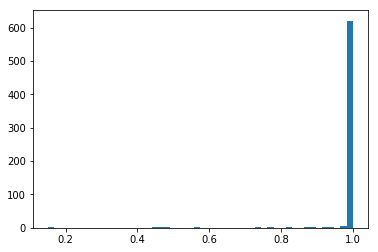

In [32]:
plt.hist([msm.active_count_fraction for msm in msms], bins=50);

In [33]:
pyemma.version

'2.5.3'

In [34]:
sum([msm.active_count_fraction != 1 for msm in msms])

31

In [35]:
sum(np.array([msm.active_count_fraction != 1 for msm in msms])), sum(((mixing_times / len(traj)) > 0.1))

(31, 8)

In [36]:
sum(np.array([msm.active_count_fraction != 1 for msm in msms]) + ((mixing_times / len(traj)) > 0.1))

32

In [37]:
all_problematic_file_indices = np.arange(len(msms))[np.array([msm.active_count_fraction != 1 for msm in msms]) + ((mixing_times / len(traj)) > 0.1)]
all_problematic_file_indices

array([  8,  34,  60,  63,  79,  80, 120, 145, 171, 183, 206, 228, 233,
       243, 266, 291, 295, 308, 324, 344, 350, 421, 424, 430, 487, 497,
       568, 569, 574, 596, 606, 610])

In [38]:
sum(np.array([msm.active_count_fraction != 1 for msm in msms]) * ((mixing_times / len(traj)) > 0.1))

7

In [39]:
def make_figure_for_insufficient_sampling(filename_index):
    index = parse_index_from_fname(traj_names[filename_index])

    smiles = smiles_list[index]
    for i in range(len(db)):
        if db[i][1] == smiles:
            print(i)
            print(db[i])
            break
    db_id, name = db[i][0], db[i][2]
    traj = md.load(traj_names[filename_index])
    pairs = get_pairs(np.arange(traj.n_atoms))

    feat = pyemma.coordinates.featurizer(traj.topology)
    feat.add_distances(pairs)

    X = feat.transform(traj)
    tica = pyemma.coordinates.tica(X, lag=20)
    y = tica.get_output()[0]


    plt.figure(figsize=(12,4))

    # placeholder for chemical structure
    ax = plt.subplot(1,3,1)
    plt.plot(np.nan, np.nan)
    plt.xticks([])
    plt.yticks([])
    plt.title('system flagged for potentially insufficient sampling:\n{}\n({})'.format(name, db_id))

    ax = plt.subplot(1,3,2)

    plt.plot(y[:,0], y[:,1], linewidth=0.5)
    plt.xlabel('tIC0')
    plt.ylabel('tIC1')
    plt.title('tICA projection')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    ax = plt.subplot(1,3,3)

    t = np.arange(len(y)) * thinning_interval / unit.nanosecond
    plt.plot(t, y[:,0], linewidth=0.5)
    plt.xlabel('simulation time (ns)')
    plt.ylabel('tIC0')
    plt.title('trace of tIC0')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()

    print('# atoms: ', traj.n_atoms)
    plt.savefig('projections/slow-mixing-projection_{}.png'.format(db_id), dpi=300, bbox_inches='tight')
    plt.close()

In [40]:
for filename_index in all_problematic_file_indices:
    make_figure_for_insufficient_sampling(filename_index)

547
['mobley_8449031', 'CCN(CC)CC', 'N,N-diethylethanamine', '-3.22', '0.60', '-1.96', '0.03', '10.1021/ct050097l', '10.1021/ct800409d', 'Experimental uncertainty not presently available, so assigned a default value.  ']
# atoms:  23
297
['mobley_4715906', 'C[C@@H]1CCCC[C@@H]1C', '1,2-dimethylcyclohexane', '1.58', '0.60', '1.69', '0.03', '10.1021/ct050097l', '10.1021/ct800409d', 'Renamed mobley_4715906 from 1,2-dimethylcyclohexane to (1R,2S)-1,2-dimethylcyclohexane (the name from the 3D structure) since the former did not completely specify stereochemistry.  ']
# atoms:  24
102
['mobley_2183616', 'CC[C@H](C)c1ccccc1', 'sec-butylbenzene', '-0.45', '0.60', '-0.22', '0.03', '10.1021/ct050097l', '10.1021/ct800409d', 'Renamed mobley_2183616 from sec-butylbenzene to [(1S)-1-methylpropyl]benzene (the name from the 3D structure) since the former did not completely specify stereochemistry.  ']
# atoms:  24
498
['mobley_7676709', 'CC1=CC(=O)[C@@H](CC1)C(C)C', '6-isopropyl-3-methyl-1-cyclohex-2-e

# atoms:  27
461
['mobley_7106722', 'CCCC(C)C', 'isohexane', '2.51', '0.60', '2.81', '0.03', '10.1021/ct050097l', '10.1021/ct800409d', 'Experimental uncertainty not presently available, so assigned a default value.  ']
# atoms:  20
257
['mobley_4177472', 'CC(C)C(C)C(C)C', '2,3,4-trimethylpentane', '2.56', '0.60', '2.67', '0.03', '10.1021/ct050097l', '10.1021/ct800409d', 'Experimental uncertainty not presently available, so assigned a default value.  ']
# atoms:  26
248
['mobley_3982371', 'CC(=O)OC', 'methyl acetate', '-3.13', '0.60', '-3.83', '0.02', '10.1021/ct050097l', '10.1021/ct800409d', 'Experimental uncertainty not presently available, so assigned a default value.  ']
# atoms:  11
